# Correlations before and after attack
## Using the Kendall correlation scheme

Example: one new qcd file

Always using the same scale (-1,1) for the correlations

ToDo: with the old datasets; abs(...); how to deal with defaults in the attacks; apply for scaled inputs instead of scaled-back inputs

## Preparations

### Loading modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
import uproot4 as uproot

In [2]:
import torch
import torch.nn as nn

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

### Configure the device

In [3]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Plot styling

In [4]:
plt.style.use([hep.style.ROOT, hep.style.firamath])

### Opening the files

##### First one of the new set of QCD files

In [5]:
#file = "root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/user/anovak/PFNano/106X_v2_17/QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8/RunIIFall17PFNanoAODv2-PU2017_12Apr2018_94X_mc2017_realistic_v14-v1PFNanoV2/210101_173148/0001/nano_mc2017_1-1048.root"

Now also available locally

In [6]:
file = "/home/um106329/aisafety/information_datasets/nano_mc2017_1-1048.root"

In [7]:
tree = uproot.open(file, library='pd')['Events']
#tree.keys()

## Create dataframe, do some cleaning

In [8]:
jet_input_branches = ["event", "Jet_pt","Jet_eta", "Jet_hadronFlavour", "Jet_nBHadrons", "Jet_btagDeepB", "Jet_btagDeepFlavB"]
deepCSV_input_branches = [x for x in tree.keys() if 'Jet_DeepCSV' in x]
jet_input_branches.extend(deepCSV_input_branches)
deepCSV_input_branches = ["Jet_pt", "Jet_eta"] + deepCSV_input_branches

In [9]:
df = tree.arrays(jet_input_branches, library='pd')
df.unstack()
df

event      Jet_pt   Jet_eta  Jet_hadronFlavour  \
entry subentry                                                       
0     0          76071929  671.500000 -0.122818                  0   
      1          76071929  448.500000  0.105759                  0   
      2          76071929  270.750000 -0.360352                  0   
      3          76071929   41.687500 -0.462341                  0   
1     0          76071845  400.750000 -0.002752                  0   
...                   ...         ...       ...                ...   
7738  4         174676315   27.671875  2.825684                  0   
      5         174676315   23.281250 -2.705078                  0   
      6         174676315   20.093750  0.387329                  0   
      7         174676315   19.109375 -3.816406                  0   
      8         174676315   16.796875 -1.479736                  0   

                Jet_nBHadrons  Jet_btagDeepB  Jet_btagDeepFlavB  \
entry subentry                                                    
0     0                     0       0.112854           0.086853   
      1                     0       0.030960           0.021286   
      2                     0       0.048584           0.020294   
      3                     0       0.071228           0.332520   
1     0                     0       0.025467           0.014442   
...                       ...            ...                ...   
7738  4                     0      -1.000000           0.207275   
      5                     0       0.194458           0.283691   
      6                     0      -1.000000           0.041840   
      7                     0      -1.000000           0.192505   
      8                     0       0.137573           0.104614   

                Jet_DeepCSV_flightDistance2dSig  \
entry subentry                                    
0     0                               20.640625   
      1                             -999.000000   
      2                                3.375000   
      3                                4.468750   
1     0                             -999.000000   
...                                         ...   
7738  4                             -999.000000   
      5                             -999.000000   
      6                             -999.000000   
      7                             -999.000000   
      8                             -999.000000   

                Jet_DeepCSV_flightDistance2dVal  \
entry subentry                                    
0     0                                1.925781   
      1                             -999.000000   
      2                                0.131958   
      3                                0.060944   
1     0                             -999.000000   
...                                         ...   
7738  4                             -999.000000   
      5                             -999.000000   
      6                             -999.000000   
      7                             -999.000000   
      8                             -999.000000   

                Jet_DeepCSV_flightDistance3dSig  ...  \
entry subentry                                   ...   
0     0                               20.671875  ...   
      1                             -999.000000  ...   
      2                                3.345703  ...   
      3                                4.500000  ...   
1     0                             -999.000000  ...   
...                                         ...  ...   
7738  4                             -999.000000  ...   
      5                             -999.000000  ...   
      6                             -999.000000  ...   
      7                             -999.000000  ...   
      8                             -999.000000  ...   

                Jet_DeepCSV_trackSumJetDeltaR  Jet_DeepCSV_trackSumJetEtRatio  \
entry subentry                                                                  
0     0           

### (0'th cleaning step: cuts on Jet Pt and Jet Eta)


In [10]:
df = df[(df['Jet_pt']>25) & (abs(df['Jet_eta'])<2.5)]

In [11]:
df = df.reset_index()

### Cleaning of the deepCSV inputs
based on NaN or infinities

In [12]:
pd.options.mode.use_inf_as_na = False

In [13]:
df[deepCSV_input_branches]

Jet_pt   Jet_eta  Jet_DeepCSV_flightDistance2dSig  \
0      671.50000 -0.122818                        20.640625   
1      448.50000  0.105759                      -999.000000   
2      270.75000 -0.360352                         3.375000   
3       41.68750 -0.462341                         4.468750   
4      400.75000 -0.002752                      -999.000000   
...          ...       ...                              ...   
34474  121.81250  1.252441                      -999.000000   
34475   56.59375  0.584351                         2.384766   
34476  554.50000  1.015625                      -999.000000   
34477  409.50000 -0.570190                         2.705078   
34478   57.03125 -0.713623                      -999.000000   

       Jet_DeepCSV_flightDistance2dVal  Jet_DeepCSV_flightDistance3dSig  \
0                             1.925781                        20.671875   
1                          -999.000000                      -999.000000   
2                             0.131958                         3.345703   
3                             0.060944                         4.500000   
4                          -999.000000                      -999.000000   
...                                ...                              ...   
34474                      -999.000000                      -999.000000   
34475                         0.013908                         2.455078   
34476                      -999.000000                      -999.000000   
34477                         0.068420                         2.736328   
34478                      -999.000000                      -999.000000   

       Jet_DeepCSV_flightDistance3dVal  Jet_DeepCSV_trackDecayLenVal_0  \
0                             2.015625                        0.040619   
1                          -999.000000                        0.173706   
2                             0.137939                        0.030930   
3                             0.067749                        0.056519   
4                          -999.000000                        0.022736   
...                                ...                             ...   
34474                      -999.000000                        0.034302   
34475                         0.016937                        0.008575   
34476                      -999.000000                        0.684082   
34477                         0.079041                        0.051300   
34478                      -999.000000                        0.018585   

       Jet_DeepCSV_trackDecayLenVal_1  Jet_DeepCSV_trackDecayLenVal_2  \
0                            0.002913                    2.525330e-03   
1                            0.027267                    6.683350e-03   
2                            0.011078                    9.832764e-02   
3                            0.003979                    6.580353e-03   
4                            0.052002                    8.468628e-03   
...                               ...                             ...   
34474                        0.000334                    2.838135e-02   
34475                        0.027359                    9.737015e-04   
34476                        0.006989                    2.350989e-38   
34477                        0.045319                    1.351166e-02   
34478                        0.035034                    1.457977e-02   

       Jet_DeepCSV_trackDecayLenVal_3  ...  Jet_DeepCSV_trackSumJetDeltaR  \
0                        3.137207e-02  ...                       0.015335   
1                        9.315491e-03  ...                       0.005322   
2                        7.708740e-02  ...                       0.004868   
3                        8.062744e-02  ...                       0.181763   
4                        6.362915e-03  ...                       0.013580   
...                               ...  ...                            ...   
34474                    4.959106e-02  ...     

In [14]:
# Typical uncleaned data
df['Jet_DeepCSV_trackDecayLenVal_4'].describe()

count    3.380600e+04
mean              inf
std               inf
min     -1.701412e+38
25%      2.756192e-24
50%      1.498413e-02
75%      6.048584e-02
max      6.812293e+37
Name: Jet_DeepCSV_trackDecayLenVal_4, dtype: float64

In [15]:
pd.options.mode.use_inf_as_na = True

In [16]:
df['Jet_DeepCSV_trackDecayLenVal_4'].describe()

count    3.380600e+04
mean              NaN
std               NaN
min     -1.701412e+38
25%      2.756192e-24
50%      1.498413e-02
75%      6.048584e-02
max      6.812293e+37
Name: Jet_DeepCSV_trackDecayLenVal_4, dtype: float64

In [17]:
df[deepCSV_input_branches].isna().mean().tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.008236897821862583,
 0.004263464717654224,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.0,
 0.0,
 0.005916644914295658,
 0.0034513762000058005,
 0.019519127584906756,
 0.01592273557817802,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [18]:
df = df.fillna(-999)

In [19]:
df[deepCSV_input_branches].isna().mean().tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [20]:
df = df.applymap(lambda x: -999 if x < -999 else x)
df = df.applymap(lambda x: -999 if x > 1000 else x)

In [21]:
df.describe()

entry      subentry    event        Jet_pt       Jet_eta  \
count  34479.000000  34479.000000  34479.0  34479.000000  34479.000000   
mean    -807.438412      2.110009   -999.0    252.722607      0.001081   
std      510.832587      1.846789      0.0    203.935091      1.154646   
min     -999.000000      0.000000   -999.0     25.015625     -2.499023   
25%     -999.000000      1.000000   -999.0     56.953125     -0.874878   
50%     -999.000000      2.000000   -999.0    192.625000      0.003799   
75%     -999.000000      3.000000   -999.0    443.250000      0.877075   
max     1000.000000     13.000000   -999.0    867.500000      2.499512   

       Jet_hadronFlavour  Jet_nBHadrons  Jet_btagDeepB  Jet_btagDeepFlavB  \
count       34479.000000   34479.000000   34479.000000       34479.000000   
mean            0.541518       0.051046       0.089139           0.085073   
std             1.438335       0.269285       0.216921           0.187782   
min             0.000000       0.000000      -1.000000           0.001214   
25%             0.000000       0.000000       0.026764           0.008636   
50%             0.000000       0.000000       0.046722           0.017990   
75%             0.000000       0.000000       0.103394           0.055084   
max             5.000000       4.000000       0.999512           0.999512   

       Jet_DeepCSV_flightDistance2dSig  ...  Jet_DeepCSV_trackSumJetDeltaR  \
count                     34479.000000  ...                   34479.000000   
mean                       -652.797305  ...                      -2.725652   
std                         480.054822  ...                      52.644612   
min                        -999.000000  ...                    -999.000000   
25%                        -999.000000  ...                       0.008751   
50%                        -999.000000  ...                       0.018448   
75%                           3.038086  ...                       0.039597   
max                         780.000000  ...                       3.912109   

       Jet_DeepCSV_trackSumJetEtRatio  Jet_DeepCSV_vertexCategory  \
count                    34479.000000                34479.000000   
mean                        -2.248688                   -1.512979   
std                         52.669709                   52.716463   
min                       -999.000000                 -999.000000   
25%                          0.395996                    0.000000   
50%                          0.538574                    2.000000   
75%                          0.672852                    2.000000   
max                          4.910156                    2.000000   

       Jet_DeepCSV_vertexEnergyRatio  Jet_DeepCSV_vertexJetDeltaR  \
count                   34479.000000                 34479.000000   
mean                     -615.908165                  -616.007912   
std                       485.897970                   485.771146   
min                      -999.000000                  -999.000000   
25%                      -999.000000                  -999.000000   
50%                      -999.000000                  -999.000000   
75%                         0.178589                     0.055542   
max                        79.875000                     0.300049   

       Jet_DeepCSV_vertexMass  Jet_DeepCSV_jetNSecondaryVertices  \
count            34479.000000                       34479.000000   
mean              -613.411867                           0.426811   
std                489.117390                           0.673882   
min               -999.000000                           0.000000   
25%               -999.000000                           0.000000   
50%               -999.000000                           0.000000   
75%                  1.932617                           1.000000   
max                183.750000                           7.000000   

       Jet_DeepCSV_jetNSelectedTracks  Jet_DeepCSV_jetNTracksEtaRel  \
count                 

## So far:
Defaults have been given the value -999 (if they were <-999 or >1000 or Nan or +-inf).
Now, these defaults will be shifted

#### Default = -10

In [34]:
default_val = -10

In [22]:
df = df.applymap(lambda x: default_val if (x == -999) else x)

## Applying the attack

The inputs have to be prepared, cleaning is considered "done". But in order to use the attack, the inputs shall be scaled by (x-mu)/sigma.
Besides that, we need the true target classes, otherwise calculations involving the loss function (fgsm) would fail.
And in order to use the correct model, it has to be loaded together with the criterion & optimizer.

### Names to identify the variables, to display them in plots

In [23]:
input_names = ['Jet_eta', 'Jet_pt',
 'Jet_DeepCSV_flightDistance2dSig', 'Jet_DeepCSV_flightDistance2dVal', 'Jet_DeepCSV_flightDistance3dSig', 'Jet_DeepCSV_flightDistance3dVal',
 'Jet_DeepCSV_trackDecayLenVal_0', 'Jet_DeepCSV_trackDecayLenVal_1', 'Jet_DeepCSV_trackDecayLenVal_2', 'Jet_DeepCSV_trackDecayLenVal_3', 'Jet_DeepCSV_trackDecayLenVal_4', 'Jet_DeepCSV_trackDecayLenVal_5',
 'Jet_DeepCSV_trackDeltaR_0', 'Jet_DeepCSV_trackDeltaR_1', 'Jet_DeepCSV_trackDeltaR_2', 'Jet_DeepCSV_trackDeltaR_3', 'Jet_DeepCSV_trackDeltaR_4', 'Jet_DeepCSV_trackDeltaR_5',
 'Jet_DeepCSV_trackEtaRel_0', 'Jet_DeepCSV_trackEtaRel_1', 'Jet_DeepCSV_trackEtaRel_2', 'Jet_DeepCSV_trackEtaRel_3',
 'Jet_DeepCSV_trackJetDistVal_0', 'Jet_DeepCSV_trackJetDistVal_1', 'Jet_DeepCSV_trackJetDistVal_2', 'Jet_DeepCSV_trackJetDistVal_3', 'Jet_DeepCSV_trackJetDistVal_4', 'Jet_DeepCSV_trackJetDistVal_5',
 'Jet_DeepCSV_trackJetPt',
 'Jet_DeepCSV_trackPtRatio_0', 'Jet_DeepCSV_trackPtRatio_1', 'Jet_DeepCSV_trackPtRatio_2', 'Jet_DeepCSV_trackPtRatio_3', 'Jet_DeepCSV_trackPtRatio_4', 'Jet_DeepCSV_trackPtRatio_5',
 'Jet_DeepCSV_trackPtRel_0', 'Jet_DeepCSV_trackPtRel_1', 'Jet_DeepCSV_trackPtRel_2', 'Jet_DeepCSV_trackPtRel_3', 'Jet_DeepCSV_trackPtRel_4', 'Jet_DeepCSV_trackPtRel_5',
 'Jet_DeepCSV_trackSip2dSigAboveCharm',
 'Jet_DeepCSV_trackSip2dSig_0', 'Jet_DeepCSV_trackSip2dSig_1', 'Jet_DeepCSV_trackSip2dSig_2', 'Jet_DeepCSV_trackSip2dSig_3', 'Jet_DeepCSV_trackSip2dSig_4', 'Jet_DeepCSV_trackSip2dSig_5',
 'Jet_DeepCSV_trackSip2dValAboveCharm',
 'Jet_DeepCSV_trackSip3dSigAboveCharm',
 'Jet_DeepCSV_trackSip3dSig_0', 'Jet_DeepCSV_trackSip3dSig_1', 'Jet_DeepCSV_trackSip3dSig_2', 'Jet_DeepCSV_trackSip3dSig_3', 'Jet_DeepCSV_trackSip3dSig_4', 'Jet_DeepCSV_trackSip3dSig_5',
 'Jet_DeepCSV_trackSip3dValAboveCharm',
 'Jet_DeepCSV_trackSumJetDeltaR', 'Jet_DeepCSV_trackSumJetEtRatio',
 'Jet_DeepCSV_vertexCategory', 'Jet_DeepCSV_vertexEnergyRatio', 'Jet_DeepCSV_vertexJetDeltaR', 'Jet_DeepCSV_vertexMass',
 'Jet_DeepCSV_jetNSecondaryVertices', 'Jet_DeepCSV_jetNSelectedTracks', 'Jet_DeepCSV_jetNTracksEtaRel', 'Jet_DeepCSV_vertexNTracks',]

display_names = ['Jet $\eta$',
                'Jet $p_T$',
                'Flight Distance 2D Sig','Flight Distance 2D Val','Flight Distance 3D Sig', 'Flight Distance 3D Val',
                'Track Decay Len Val [0]','Track Decay Len Val [1]','Track Decay Len Val [2]','Track Decay Len Val [3]','Track Decay Len Val [4]','Track Decay Len Val [5]',
                'Track $\Delta R$ [0]','Track $\Delta R$ [1]','Track $\Delta R$ [2]','Track $\Delta R$ [3]','Track $\Delta R$ [4]','Track $\Delta R$ [5]',
                'Track $\eta_{rel}$ [0]','Track $\eta_{rel}$ [1]','Track $\eta_{rel}$ [2]','Track $\eta_{rel}$ [3]',
                'Track Jet Dist Val [0]','Track Jet Dist Val [1]','Track Jet Dist Val [2]','Track Jet Dist Val [3]','Track Jet Dist Val [4]','Track Jet Dist Val [5]',
                'Track Jet $p_T$',
                'Track $p_T$ Ratio [0]','Track $p_T$ Ratio [1]','Track $p_T$ Ratio [2]','Track $p_T$ Ratio [3]','Track $p_T$ Ratio [4]','Track $p_T$ Ratio [5]',
                'Track $p_{T,rel}$ [0]','Track $p_{T,rel}$ [1]','Track $p_{T,rel}$ [2]','Track $p_{T,rel}$ [3]','Track $p_{T,rel}$ [4]','Track $p_{T,rel}$ [5]',
                'Track SIP 2D Sig Above Charm',
                'Track SIP 2D Sig [0]','Track SIP 2D Sig [1]','Track SIP 2D Sig [2]','Track SIP 2D Sig [3]','Track SIP 2D Sig [4]','Track SIP 2D Sig [5]',
                'Track SIP 2D Val Above Charm',
                'Track SIP 3D Sig Above Charm',
                'Track SIP 3D Sig [0]','Track SIP 3D Sig [1]','Track SIP 3D Sig [2]','Track SIP 3D Sig [3]','Track SIP 3D Sig [4]','Track SIP 3D Sig [5]',
                'Track SIP 3D Val Above Charm',
                'Track Sum Jet $\Delta R$','Track Sum Jet $E_T$ Ratio',
                'Vertex Category','Vertex Energy Ratio','Vertex Jet $\Delta R$','Vertex Mass',
                'Jet N Secondary Vertices','Jet N Selected Tracks','Jet N Tracks $\eta_{rel}$','Vertex N Tracks',]

### Loading the model with all its additional properties
This is the newest, non-weighted model (fully trained after 120 epochs)

In [24]:
criterion = nn.CrossEntropyLoss()

model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))

checkpoint = torch.load(f'/home/um106329/aisafety/models/weighted/200_full_files_120_epochs_v13_GPU_weighted_as_is.pt', map_location=torch.device(device))
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)
model.eval()

Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)

### Creating the true flavour class (target_class) as a new column for the dataframe
Using the definitions from my initial cleandataset function

In [25]:
df["target_class"] = np.full_like(df['Jet_hadronFlavour'], 3)
df["target_class"] = np.where(df['Jet_hadronFlavour'] == 4, 2, df["target_class"])
df["target_class"] = np.where(np.bitwise_and(df['Jet_hadronFlavour'] == 5, df['Jet_nBHadrons'] > 1), 1, df["target_class"])
df["target_class"] = np.where(np.bitwise_and(df['Jet_hadronFlavour'] == 5, df['Jet_nBHadrons'] <= 1), 0, df["target_class"])

And check that the column has been added correctly:

In [26]:
df.head()

entry  subentry  event    Jet_pt   Jet_eta  Jet_hadronFlavour  \
0      0         0    -10  671.5000 -0.122818                  0   
1      0         1    -10  448.5000  0.105759                  0   
2      0         2    -10  270.7500 -0.360352                  0   
3      0         3    -10   41.6875 -0.462341                  0   
4      1         0    -10  400.7500 -0.002752                  0   

   Jet_nBHadrons  Jet_btagDeepB  Jet_btagDeepFlavB  \
0              0       0.112854           0.086853   
1              0       0.030960           0.021286   
2              0       0.048584           0.020294   
3              0       0.071228           0.332520   
4              0       0.025467           0.014442   

   Jet_DeepCSV_flightDistance2dSig  ...  Jet_DeepCSV_trackSumJetEtRatio  \
0                        20.640625  ...                        0.459961   
1                       -10.000000  ...                        0.380615   
2                         3.375000  ...                        0.499512   
3                         4.468750  ...                        4.453125   
4                       -10.000000  ...                        0.711426   

   Jet_DeepCSV_vertexCategory  Jet_DeepCSV_vertexEnergyRatio  \
0                         0.0                       0.014397   
1                         2.0                     -10.000000   
2                         0.0                       0.140747   
3                         0.0                       0.236938   
4                         1.0                       0.029877   

   Jet_DeepCSV_vertexJetDeltaR  Jet_DeepCSV_vertexMass  \
0                     0.187744                0.617188   
1                   -10.000000              -10.000000   
2                     0.066162                1.732422   
3                     0.072998                5.492188   
4                     0.102783                0.333496   

   Jet_DeepCSV_jetNSecondaryVertices  Jet_DeepCSV_jetNSelectedTracks  \
0                                  1                              14   
1                                  0                               9   
2                                  1                               4   
3                                  2                               7   
4                                  0                              14   

   Jet_DeepCSV_jetNTracksEtaRel  Jet_DeepCSV_vertexNTracks  target_class  
0                             2                          2             3  
1                             0                          0             3  
2                             4                          4             3  
3                             4                          4             3  
4                             2                          2             3  

[5 rows x 75 columns]

And just some quick checks to find out the unique values of the target_class and Jet N Selected Tracks. It looks like here the cleaning did not erase the 5 tracks bin, although there also happened to be a step where we got rid off all the large values. (Which was found to be the step erasing the 5 tracks bin from my older datasets).

In [27]:
df.target_class.unique()

array([3, 2, 0, 1])

In [28]:
df.Jet_DeepCSV_jetNSelectedTracks.unique()

array([14,  9,  4,  7, 10,  5,  6,  2, 12,  3,  1, 15,  8, 11, 13,  0, 17,
       16, 20, 19, 22, 18, 21, 24, 26, 23, 25])

In [29]:
targets = torch.Tensor(df["target_class"].to_numpy()).long()

In [30]:
targets

tensor([3, 3, 3,  ..., 3, 3, 3])

### Scaling the cleaned inputs

In [31]:
all_inputs = torch.Tensor(df[deepCSV_input_branches].values[:,0:67])
norm_inputs = all_inputs.clone().detach()

scalers = []
    
for i in range(0,67):
    scaler = StandardScaler().fit(all_inputs[:,i].reshape(-1,1))
    norm_inputs[:,i] = torch.Tensor(scaler.transform(all_inputs[:,i].reshape(-1,1)).reshape(1,-1))
    scalers.append(scaler)


Should now have: scaled inputs (norm_inputs), scalers ready to be used with pytorch

In [32]:
n_jets = len(norm_inputs)
n_jets

34479

This is the total number of jets remaining after the cleaning steps above.

### Definitions of the functions used for the attacks and plotting

In [36]:
def apply_noise(magn=None,offset=0,sample=norm_inputs):
    noise = torch.Tensor(np.random.normal(offset,magn,(len(sample),67)))
    xadv = sample + noise
    # exactly like for the reduced fgsm method, the noise should not affect the integer variables or manual defaults
    xadv[:,input_names.index('Jet_DeepCSV_jetNSecondaryVertices')] = sample[:,input_names.index('Jet_DeepCSV_jetNSecondaryVertices')]
    xadv[:,input_names.index('Jet_DeepCSV_vertexCategory')] = sample[:,input_names.index('Jet_DeepCSV_vertexCategory')]
    xadv[:,input_names.index('Jet_DeepCSV_jetNSelectedTracks')] = sample[:,input_names.index('Jet_DeepCSV_jetNSelectedTracks')]
    xadv[:,input_names.index('Jet_DeepCSV_jetNTracksEtaRel')] = sample[:,input_names.index('Jet_DeepCSV_jetNTracksEtaRel')]
    xadv[:,input_names.index('Jet_DeepCSV_vertexNTracks')] = sample[:,input_names.index('Jet_DeepCSV_vertexNTracks')]
    
    # the default values were placed at e.g. -10, so something close to -10 - (-10) will end up in a small interval around zero and should not be moved by the attack
    for i in range(67):
        defaults = abs(scalers[i].inverse_transform(sample[:,i].cpu()) - default_val) < 0.001   # "floating point error" --> allow some error margin
        if np.sum(defaults) != 0:
            for i in range(67):
                xadv[:,i][defaults] = sample[:,i][defaults]
            break
            
            
    # not sure about these ones, are they necessary here?
    '''
    for i in [41, 48, 49, 56]:
        defaults = abs(scalers[i].inverse_transform(sample[:,i].cpu()) + 1.0) < 0.001   # "floating point error" --> allow some error margin
        if np.sum(defaults) != 0:
            for i in [41, 48, 49, 56]:
                xadv[:,i][defaults] = sample[:,i][defaults]
            break
    vars_with_0_defaults = [6, 7, 8, 9, 10, 11]                 # trackDecayLenVal_0 to _5
    vars_with_0_defaults.extend([12, 13, 14, 15, 16, 17])       # trackDeltaR_0 to _5
    vars_with_0_defaults.extend([18, 19, 20, 21])               # trackEtaRel_0 to _3
    vars_with_0_defaults.extend([22, 23, 24, 25, 26, 27])       # trackJetDistVal_0 to _5
    vars_with_0_defaults.extend([29, 30, 31, 32, 33, 34])       # trackPtRatio_0 to _5
    vars_with_0_defaults.extend([35, 36, 37, 38, 39, 40])       # trackPtRel_0 to _5
    for i in vars_with_0_defaults:
        defaults = abs(scalers[i].inverse_transform(sample[:,i].cpu())) < 0.001   # "floating point error" --> allow some error margin
        if np.sum(defaults) != 0:
            for i in vars_with_0_defaults:
                xadv[:,i][defaults] = sample[:,i][defaults]
            break
    '''
    
    return xadv
      

In [37]:
def fgsm_attack(epsilon=1e-1,sample=norm_inputs,targets=targets,reduced=True,scalers=scalers):
    xadv = sample.clone().detach()
    
    # calculate the gradient of the model w.r.t. the *input* tensor:
    # first we tell torch that x should be included in grad computations
    xadv.requires_grad = True
    
    # then we just do the forward and backwards pass as usual:
    preds = model(xadv)
    loss = criterion(preds, targets.long()).mean()
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        #now we obtain the gradient of the input. It has the same dimensions as the tensor xadv, and it "points" in the direction of increasing loss values.
        dx = torch.sign(xadv.grad.detach())
        
        #so, we take a step in that direction!
        xadv += epsilon*torch.sign(dx)
        
        #remove the impact on selected variables. This is nessecary to avoid problems that occur otherwise in the input shapes.
        if reduced:
            #xadv[:,2] = sample[:,2]     # TagVarCSV_jetNSecondaryVertices
            xadv[:,input_names.index('Jet_DeepCSV_jetNSecondaryVertices')] = sample[:,input_names.index('Jet_DeepCSV_jetNSecondaryVertices')]
            #xadv[:,5] = sample[:,5]     # TagVarCSV_vertexCategory
            xadv[:,input_names.index('Jet_DeepCSV_vertexCategory')] = sample[:,input_names.index('Jet_DeepCSV_vertexCategory')]
            #xadv[:,10] = sample[:,10]   # TagVarCSV_jetNSelectedTracks
            xadv[:,input_names.index('Jet_DeepCSV_jetNSelectedTracks')] = sample[:,input_names.index('Jet_DeepCSV_jetNSelectedTracks')]
            #xadv[:,11] = sample[:,11]   # TagVarCSV_jetNTracksEtaRel
            xadv[:,input_names.index('Jet_DeepCSV_jetNTracksEtaRel')] = sample[:,input_names.index('Jet_DeepCSV_jetNTracksEtaRel')]
            #xadv[:,59] = sample[:,59]   # TagVarCSV_vertexNTracks
            xadv[:,input_names.index('Jet_DeepCSV_vertexNTracks')] = sample[:,input_names.index('Jet_DeepCSV_vertexNTracks')]
            #xadv[:,12:][sample[:,12:]==0] = 0   # TagVarCSVTrk_trackJetDistVal and so forth, but I have not set any variable to 0 manually during cleaning
            #xadv[:,input_names.index('Jet_DeepCSV_trackJetDistVal_0'):][sample[:,input_names.index('Jet_DeepCSV_trackJetDistVal_0'):] == 0] = 0
            
            
            # the default values were placed at e.g. -10, so something close to -10 - (-10) will end up in a small interval around zero and should not be moved by the attack
            for i in range(67):
                defaults = abs(scalers[i].inverse_transform(sample[:,i].cpu()) - default_val) < 0.001   # "floating point error" --> allow some error margin
                if np.sum(defaults) != 0:
                    for i in range(67):
                        xadv[:,i][defaults] = sample[:,i][defaults]
                    break

            
            
            for i in [41, 48, 49, 56]:
                defaults = abs(scalers[i].inverse_transform(sample[:,i].cpu()) + 1.0) < 0.001   # "floating point error" --> allow some error margin
                if np.sum(defaults) != 0:
                    for i in [41, 48, 49, 56]:
                        xadv[:,i][defaults] = sample[:,i][defaults]
                    break
            vars_with_0_defaults = [6, 7, 8, 9, 10, 11]                 # trackDecayLenVal_0 to _5
            vars_with_0_defaults.extend([12, 13, 14, 15, 16, 17])       # trackDeltaR_0 to _5
            vars_with_0_defaults.extend([18, 19, 20, 21])               # trackEtaRel_0 to _3
            vars_with_0_defaults.extend([22, 23, 24, 25, 26, 27])       # trackJetDistVal_0 to _5
            vars_with_0_defaults.extend([29, 30, 31, 32, 33, 34])       # trackPtRatio_0 to _5
            vars_with_0_defaults.extend([35, 36, 37, 38, 39, 40])       # trackPtRel_0 to _5
            for i in vars_with_0_defaults:
                defaults = abs(scalers[i].inverse_transform(sample[:,i].cpu())) < 0.001   # "floating point error" --> allow some error margin
                if np.sum(defaults) != 0:
                    for i in vars_with_0_defaults:
                        xadv[:,i][defaults] = sample[:,i][defaults]
                    break
        return xadv.detach()
  

In [38]:
def create_distorted_inputs(attack_mode=None,parameter=0):
    if attack_mode == "noise":
        xadv = apply_noise(parameter)
    else:
        xadv = fgsm_attack(parameter)
        
    xadv_scaled_back = np.zeros([n_jets,67])
    for prop in range(67):
        xadv_scaled_back[:,prop] = scalers[prop].inverse_transform(xadv[:,prop])
        
    xadv_df = pd.DataFrame(xadv_scaled_back, index=df[deepCSV_input_branches].index, columns=df[deepCSV_input_branches].columns)
    corr_xadv = xadv_df[deepCSV_input_branches].corr('kendall')
    arr_corr_xadv = corr_xadv.to_numpy()
    
    return xadv_df, corr_xadv, arr_corr_xadv

In [39]:
def create_raw_inputs():
    raw = df[deepCSV_input_branches]
    corr_raw = raw.corr('kendall')
    arr_corr_raw = corr_raw.to_numpy()
    
    return raw, corr_raw, arr_corr_raw

In [40]:
def plot_corr(attack_mode=None, parameter=None, corr=None, arr_corr=None):
    fig, ax = plt.subplots(figsize=(24, 18))
    #hep.cms.label(loc=0)

    hm = sns.heatmap(arr_corr, cbar=True, vmin=-1, vmax=1,
                     fmt='.2f', annot_kws={'size': 3}, annot=True, 
                     square=True, cmap=plt.cm.seismic)

    ticks = np.arange(corr.shape[0]) + 0.5
    ax.set_xticks(ticks)
    ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
    ax.set_yticks(ticks)
    ax.set_yticklabels(corr.index, rotation=360, fontsize=8)
    
    if attack_mode == None:
        ax.set_title(f'Correlation matrix (Kendall) with raw inputs')
    elif attack_mode == "noise":
        ax.set_title(f'Correlation matrix (Kendall) with noise ($\sigma={parameter}$)')
    else:
        ax.set_title(f'Correlation matrix (Kendall) after FGSM ($\epsilon={parameter}$)')

    plt.tight_layout()

In [41]:
def plot_diff_corr(attack_mode=None, parameter=None, corr=None, arr_corr=None):
    diff = arr_corr_raw - arr_corr
    
    fig, ax = plt.subplots(figsize=(24, 18))
    #hep.cms.label(loc=0)

    hm = sns.heatmap(diff, cbar=True, vmin=-1, vmax=1,
                     fmt='.2f', annot_kws={'size': 3}, annot=True, 
                     square=True, cmap=plt.cm.seismic)

    ticks = np.arange(corr.shape[0]) + 0.5
    ax.set_xticks(ticks)
    ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
    ax.set_yticks(ticks)
    ax.set_yticklabels(corr.index, rotation=360, fontsize=8)
    
    if attack_mode == "noise":
        ax.set_title(f'Difference between correlation matrix (Kendall) raw and with noise ($\sigma={parameter}$)')
    else:
        ax.set_title(f'Difference between correlation matrix (Kendall) before and after FGSM with $\epsilon={parameter}$')

    plt.tight_layout()

In [42]:
def plot_rel_diff_corr(attack_mode=None, parameter=None, corr=None, arr_corr=None):
    rel_diff = (arr_corr_raw - arr_corr) / arr_corr_raw
    
    fig, ax = plt.subplots(figsize=(24, 18))
    #hep.cms.label(loc=0)

    hm = sns.heatmap(rel_diff, cbar=True, vmin=-1, vmax=1,
                     fmt='.2f', annot_kws={'size': 3}, annot=True, 
                     square=True, cmap=plt.cm.seismic)

    ticks = np.arange(corr.shape[0]) + 0.5
    ax.set_xticks(ticks)
    ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
    ax.set_yticks(ticks)
    ax.set_yticklabels(corr.index, rotation=360, fontsize=8)
    
    if attack_mode == "noise":
        ax.set_title(f'Rel. difference between correlation matrix (Kendall) raw and with noise ($\sigma={parameter}$)')
    else:
        ax.set_title(f'Rel. difference between correlation matrix (Kendall) before and after FGSM with $\epsilon={parameter}$')

    plt.tight_layout()

### Generate correlation matrices with undisturbed and disturbed inputs
... create dataframe containing the inputs, create correlations (also as dataframe), create array with correlations

Notice that although the attacks have been performed on scaled inputs ((x-mu)/sigma), the correlations were calculated from the "original" scale (after transforming them back).

A next step might do all these with the scaled inputs during the whole process.

In [43]:
raw, corr_raw, arr_corr_raw = create_raw_inputs()

In [44]:
xadv_df_noise_005, corr_xadv_noise_005, arr_corr_xadv_noise_005 = create_distorted_inputs(attack_mode="noise",parameter=0.05)

xadv_df_noise_01,  corr_xadv_noise_01,  arr_corr_xadv_noise_01  = create_distorted_inputs(attack_mode="noise",parameter=0.1)

xadv_df_noise_02,  corr_xadv_noise_02,  arr_corr_xadv_noise_02  = create_distorted_inputs(attack_mode="noise",parameter=0.2)

In [45]:
xadv_df_fgsm_0005, corr_xadv_fgsm_0005, arr_corr_xadv_fgsm_0005 = create_distorted_inputs(attack_mode="fgsm",parameter=0.005)

xadv_df_fgsm_001,  corr_xadv_fgsm_001,  arr_corr_xadv_fgsm_001  = create_distorted_inputs(attack_mode="fgsm",parameter=0.01)

xadv_df_fgsm_002,  corr_xadv_fgsm_002,  arr_corr_xadv_fgsm_002  = create_distorted_inputs(attack_mode="fgsm",parameter=0.02)

... and plot the correlations, their differences compared to raw and the relative differences

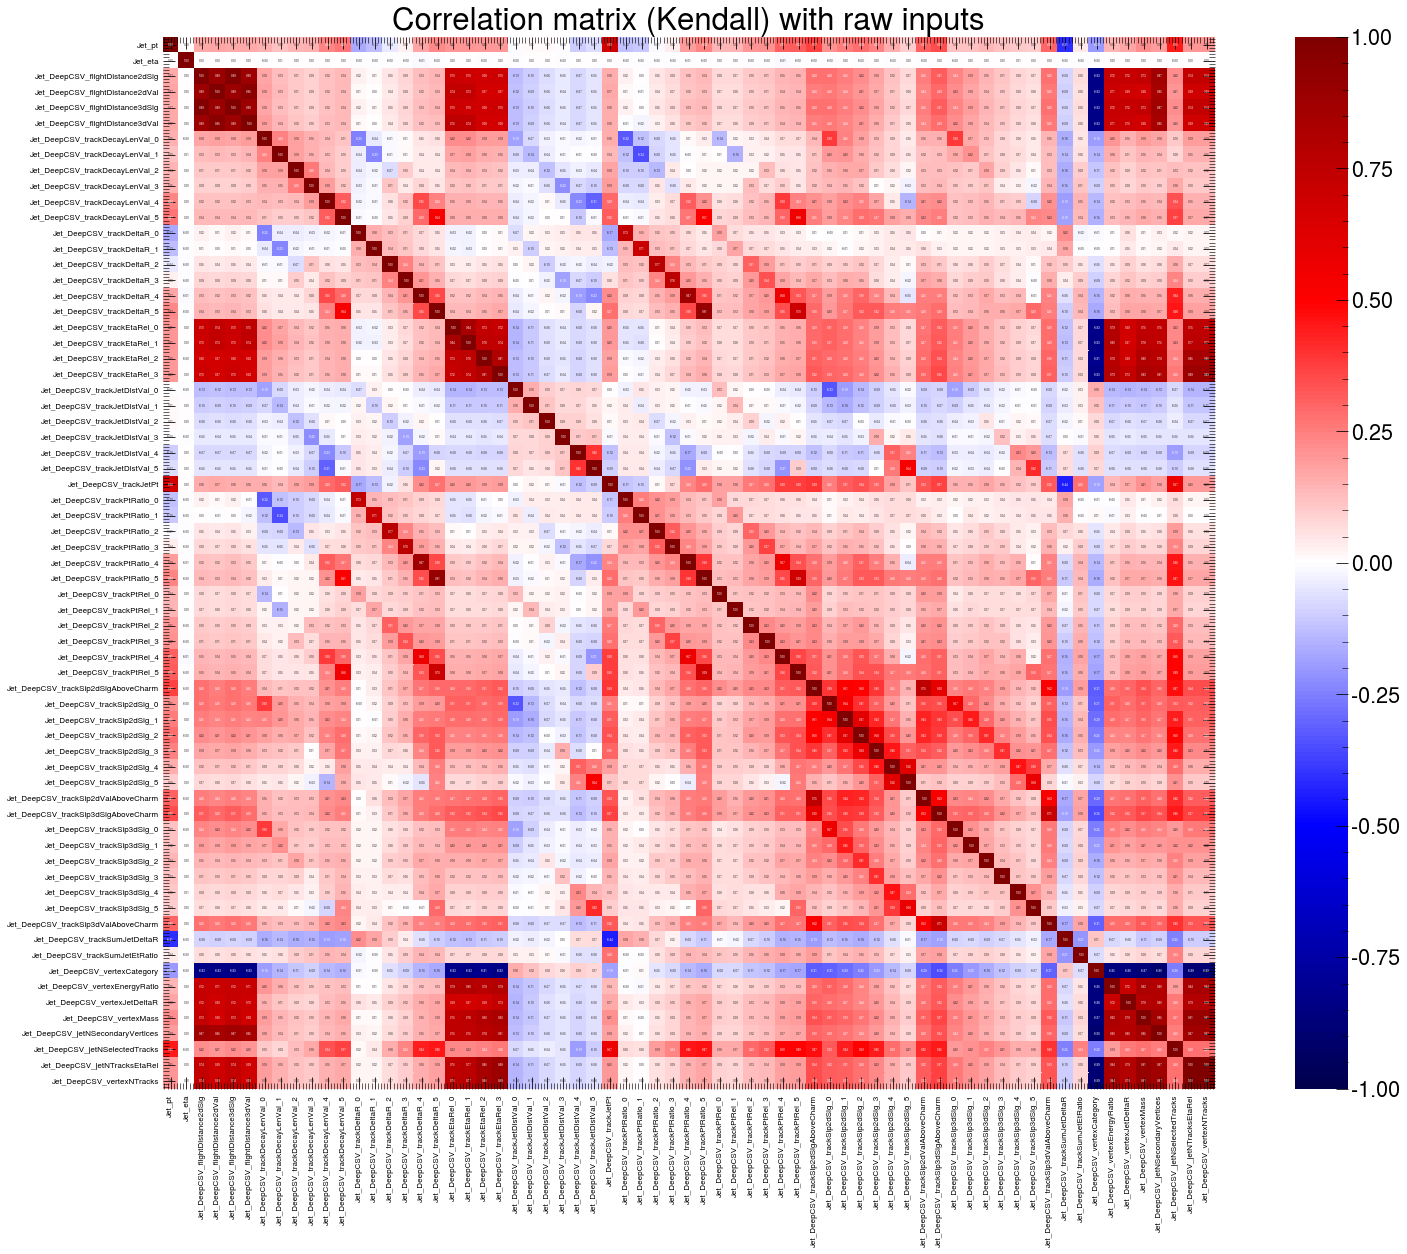

In [46]:
plot_corr(attack_mode=None, parameter=None, corr=corr_raw, arr_corr=arr_corr_raw)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


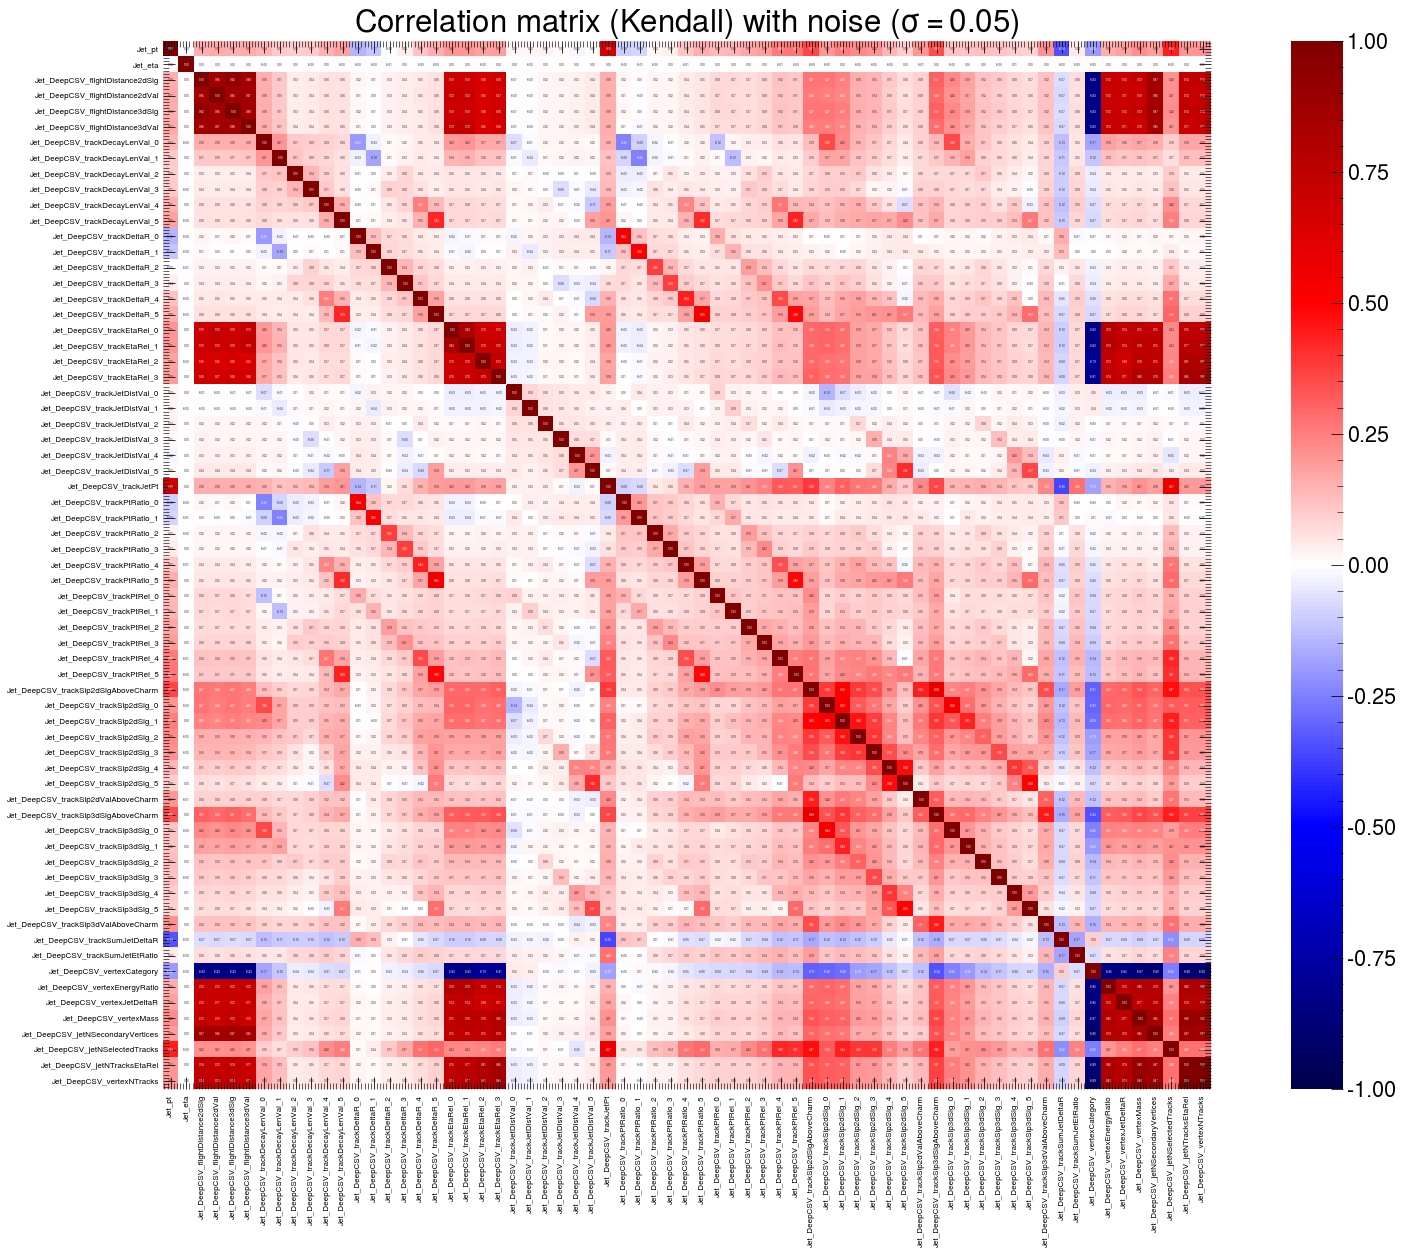

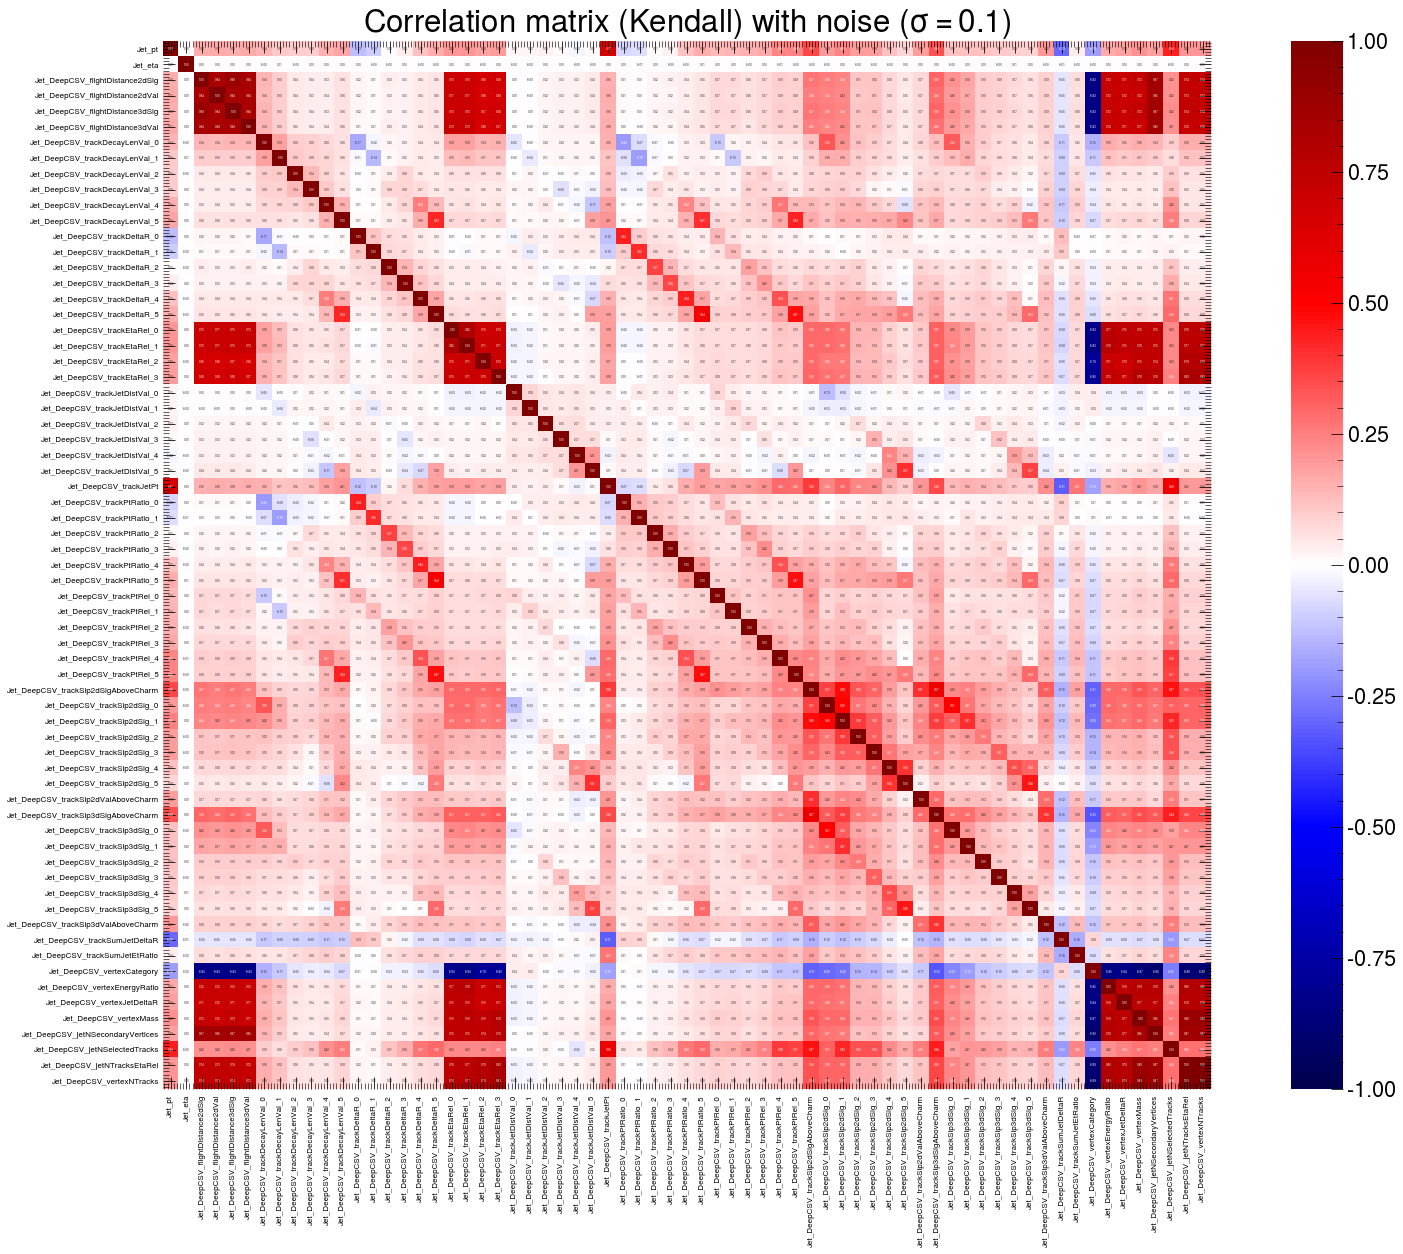

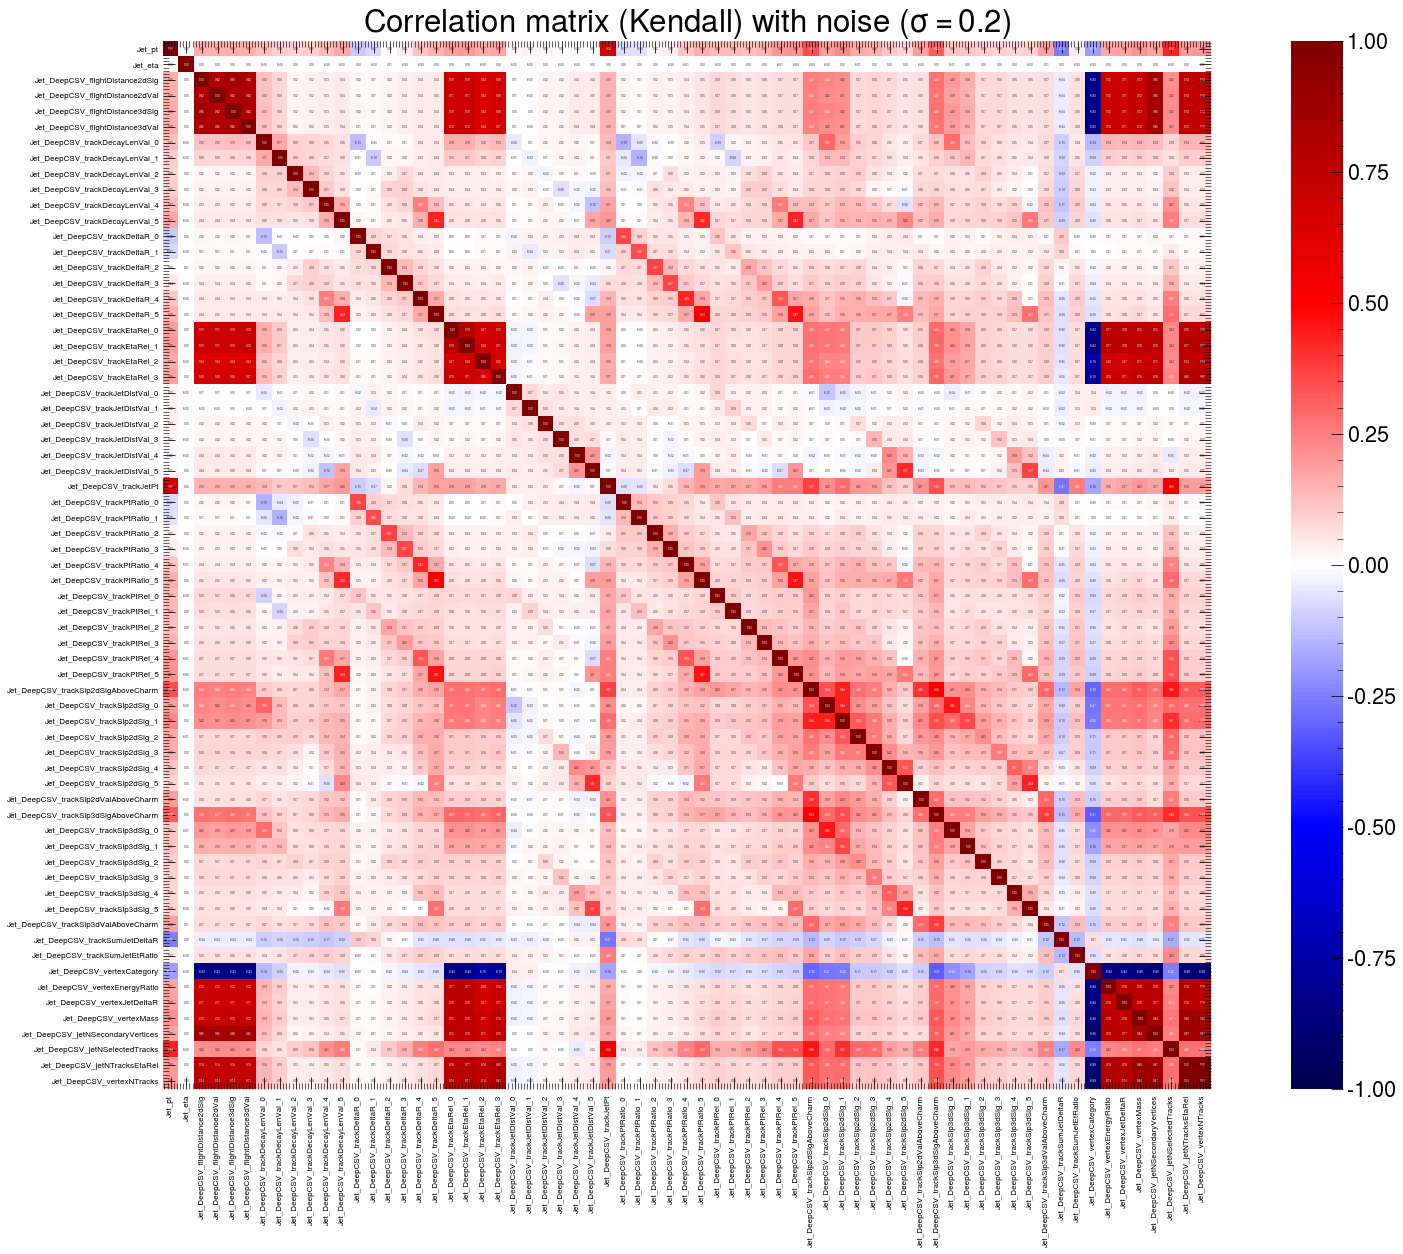

In [47]:
plot_corr(attack_mode="noise", parameter=0.05, corr=corr_xadv_noise_005, arr_corr=arr_corr_xadv_noise_005)
plot_corr(attack_mode="noise", parameter=0.1,  corr=corr_xadv_noise_01,  arr_corr=arr_corr_xadv_noise_01)
plot_corr(attack_mode="noise", parameter=0.2,  corr=corr_xadv_noise_02,  arr_corr=arr_corr_xadv_noise_02)

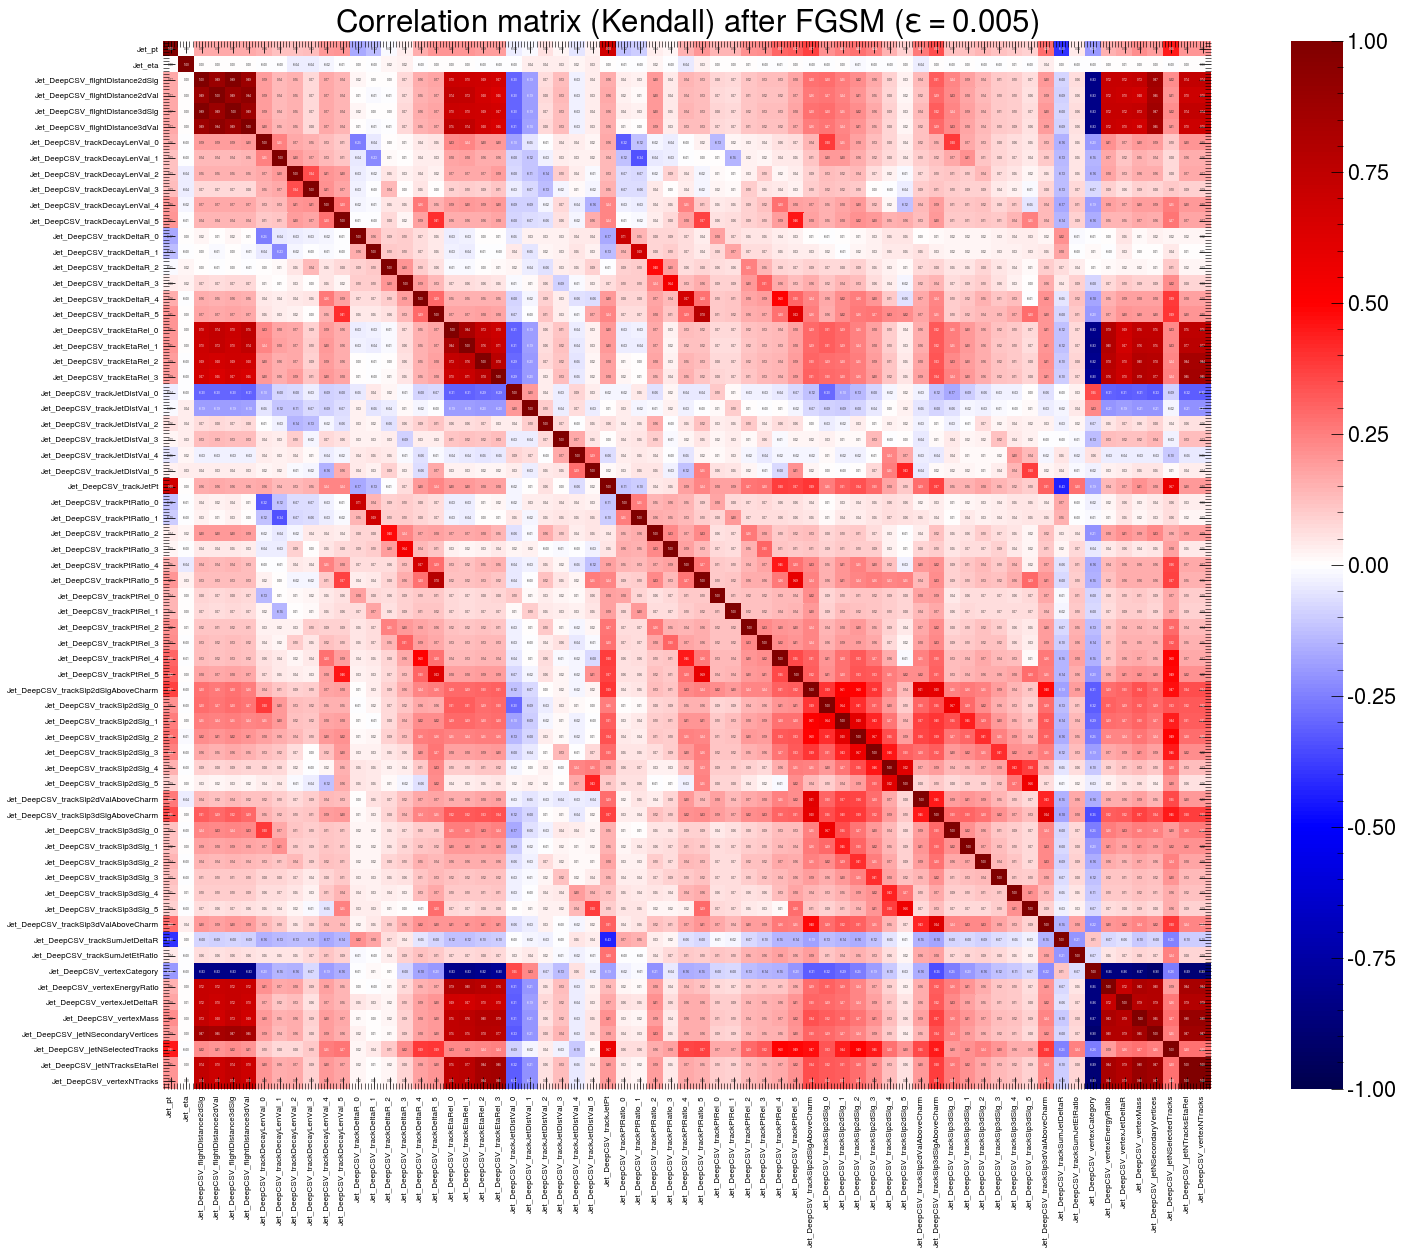

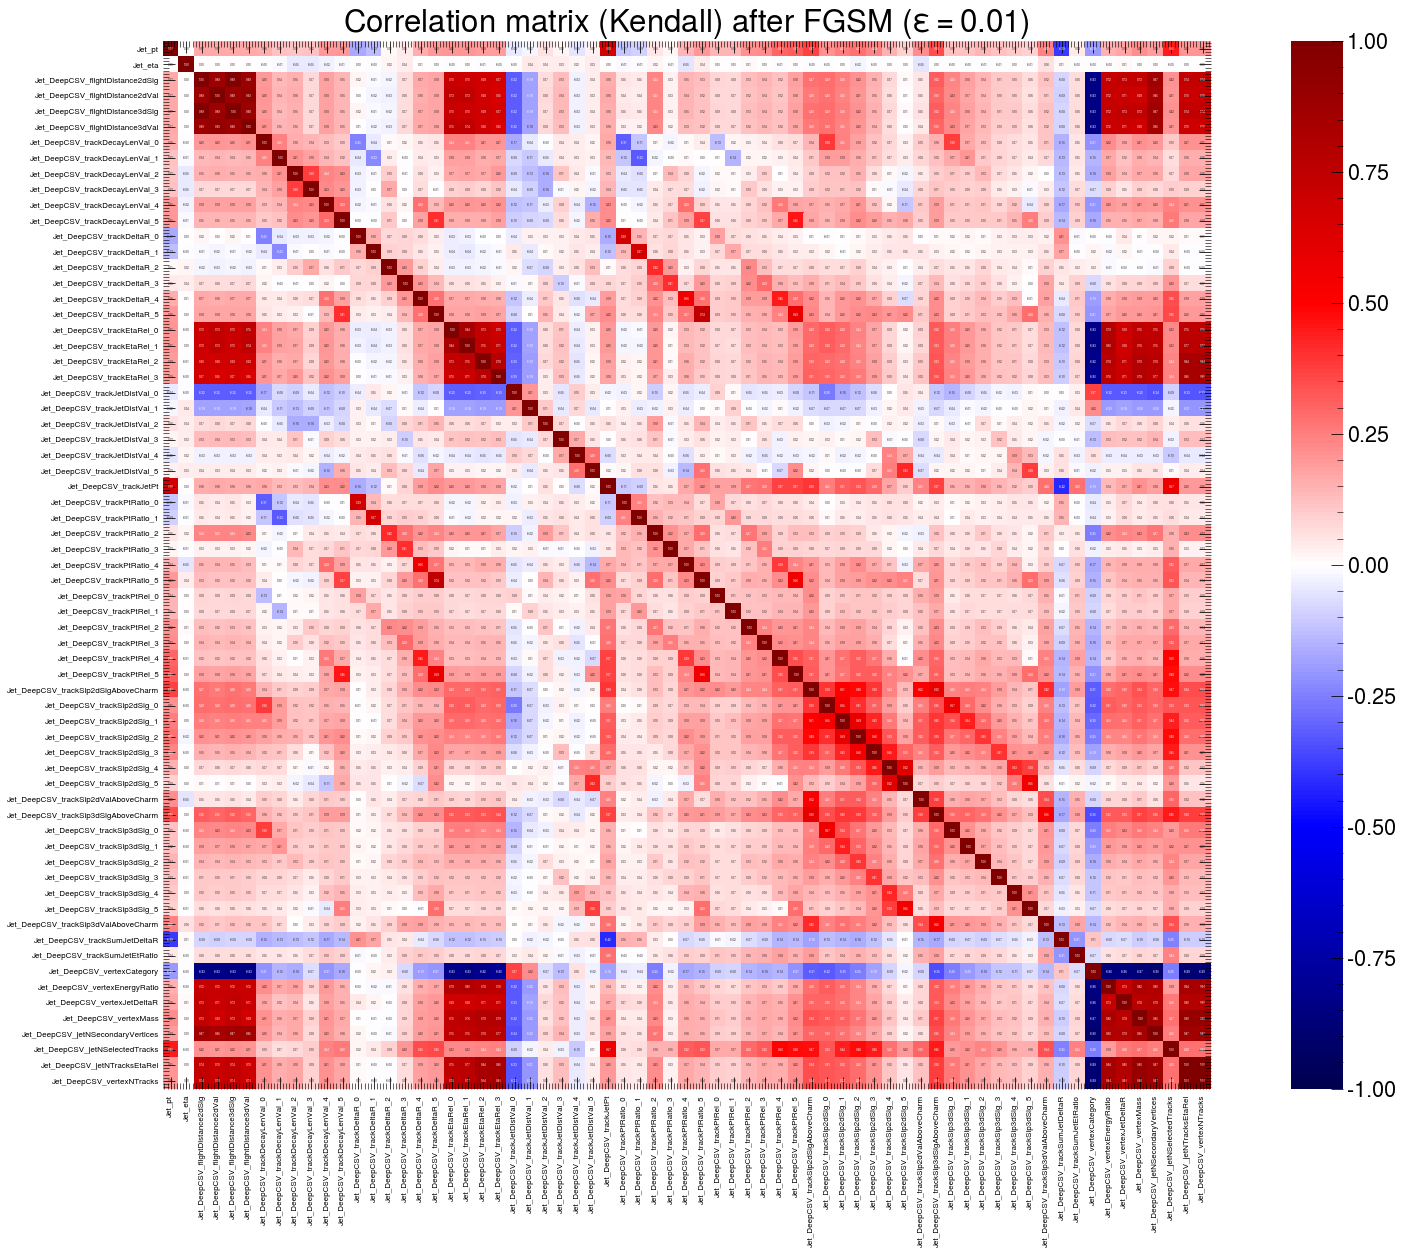

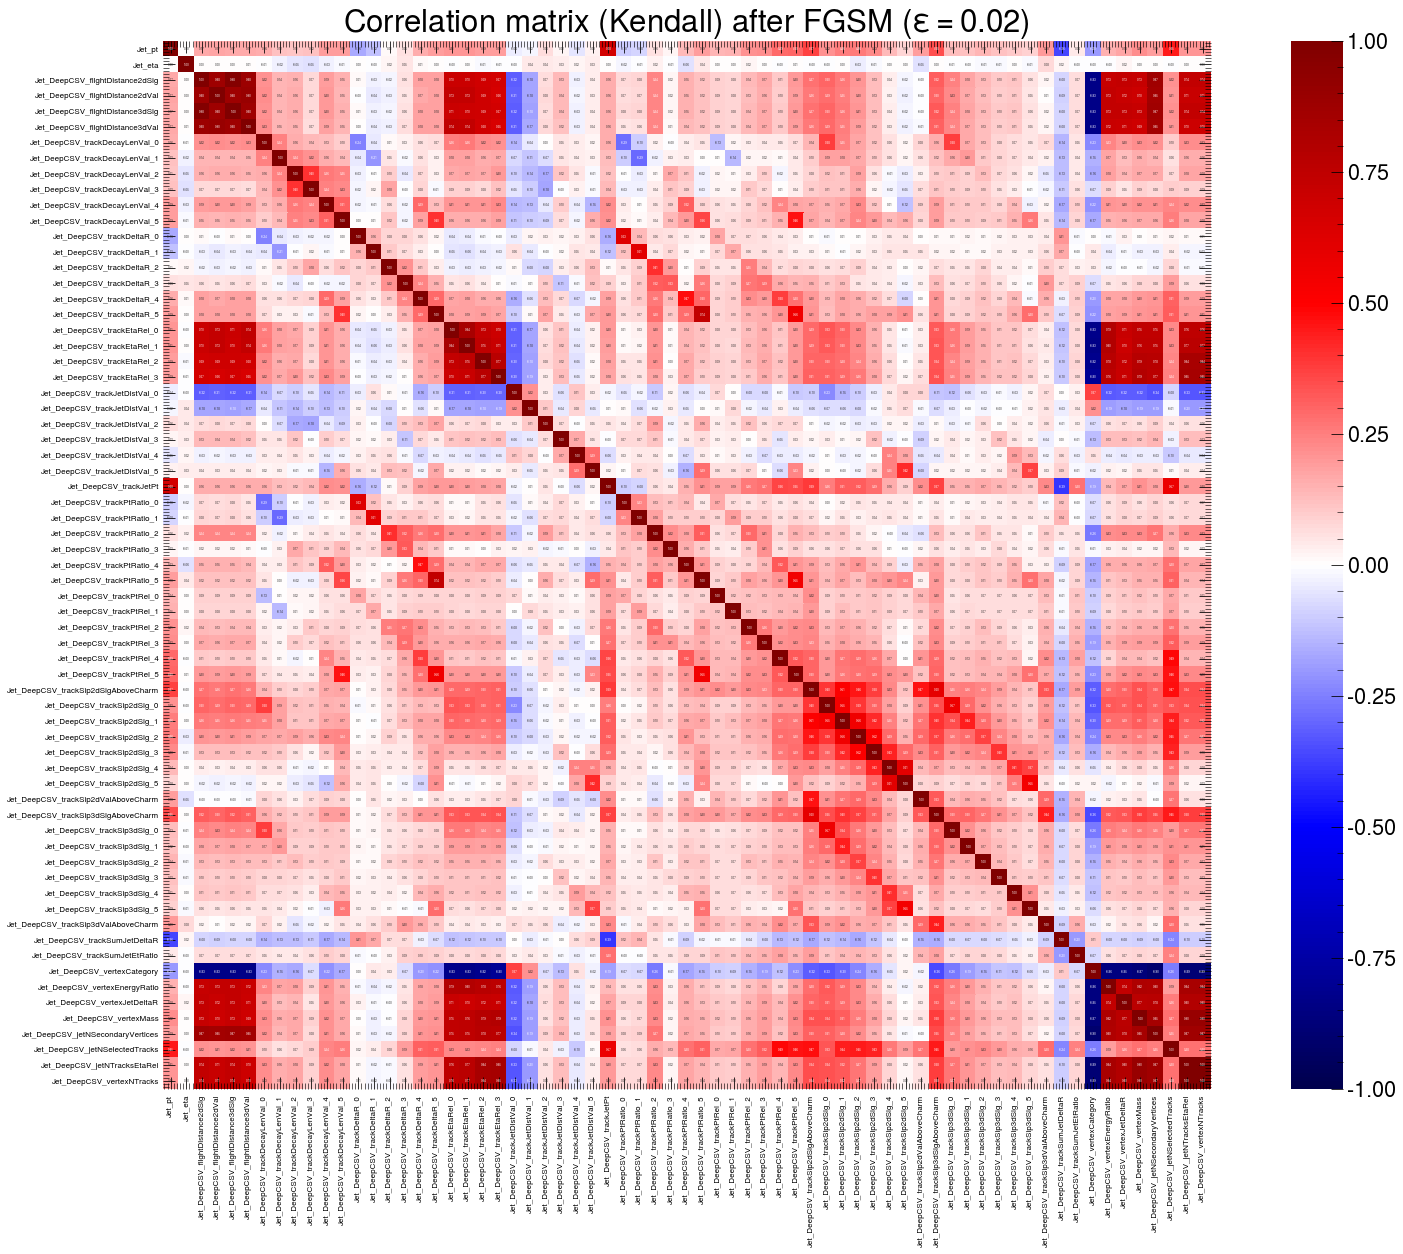

In [48]:
plot_corr(attack_mode="fgsm", parameter=0.005, corr=corr_xadv_fgsm_0005, arr_corr=arr_corr_xadv_fgsm_0005)
plot_corr(attack_mode="fgsm", parameter=0.01, corr=corr_xadv_fgsm_001, arr_corr=arr_corr_xadv_fgsm_001)
plot_corr(attack_mode="fgsm", parameter=0.02, corr=corr_xadv_fgsm_002, arr_corr=arr_corr_xadv_fgsm_002)

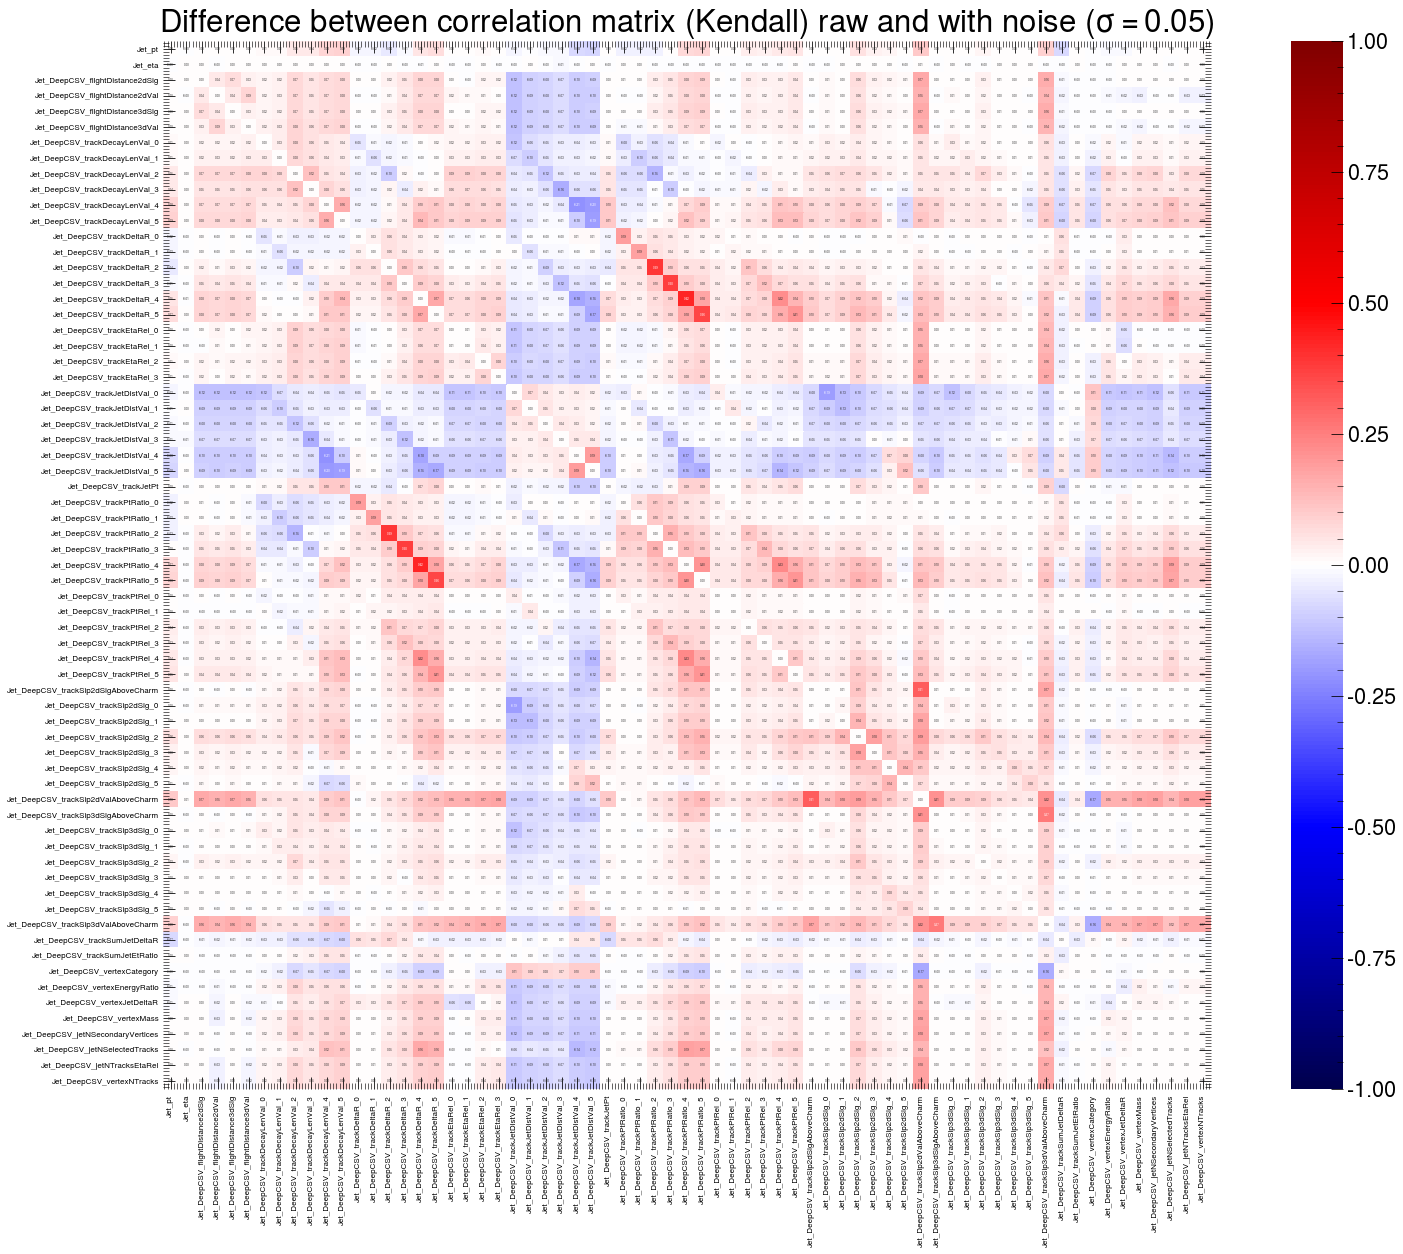

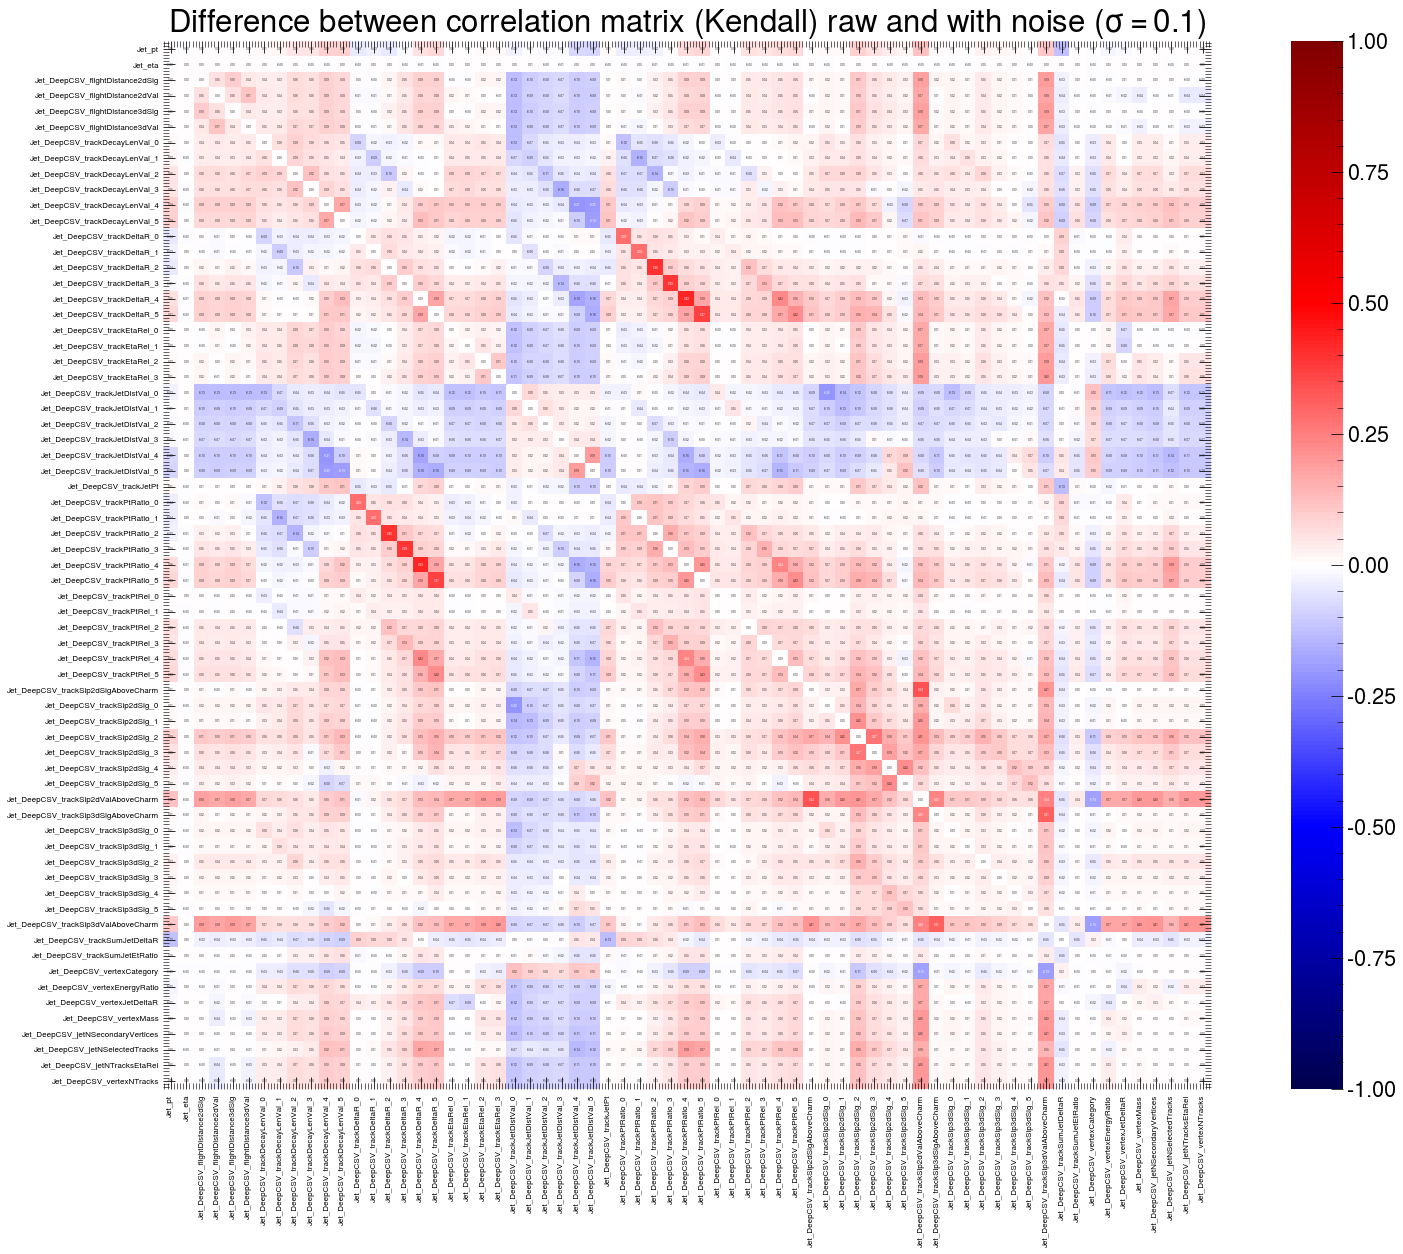

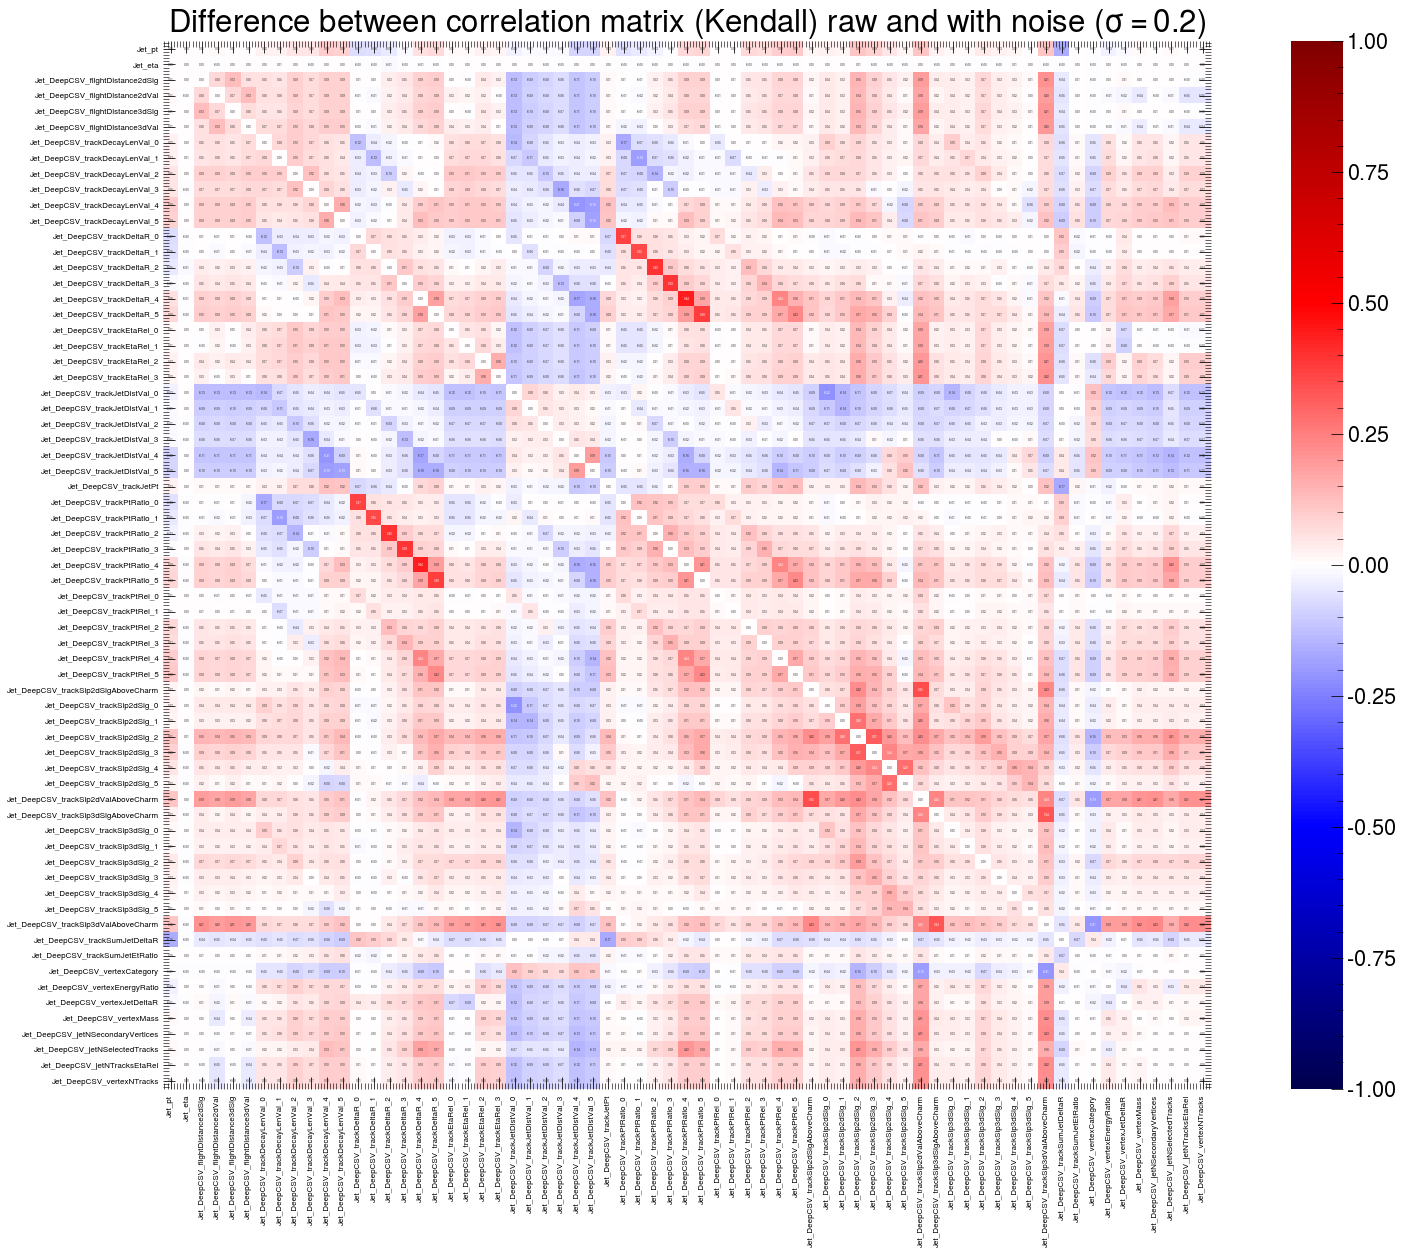

In [49]:
plot_diff_corr(attack_mode="noise", parameter=0.05, corr=corr_xadv_noise_005, arr_corr=arr_corr_xadv_noise_005)
plot_diff_corr(attack_mode="noise", parameter=0.1, corr=corr_xadv_noise_01, arr_corr=arr_corr_xadv_noise_01)
plot_diff_corr(attack_mode="noise", parameter=0.2, corr=corr_xadv_noise_02, arr_corr=arr_corr_xadv_noise_02)

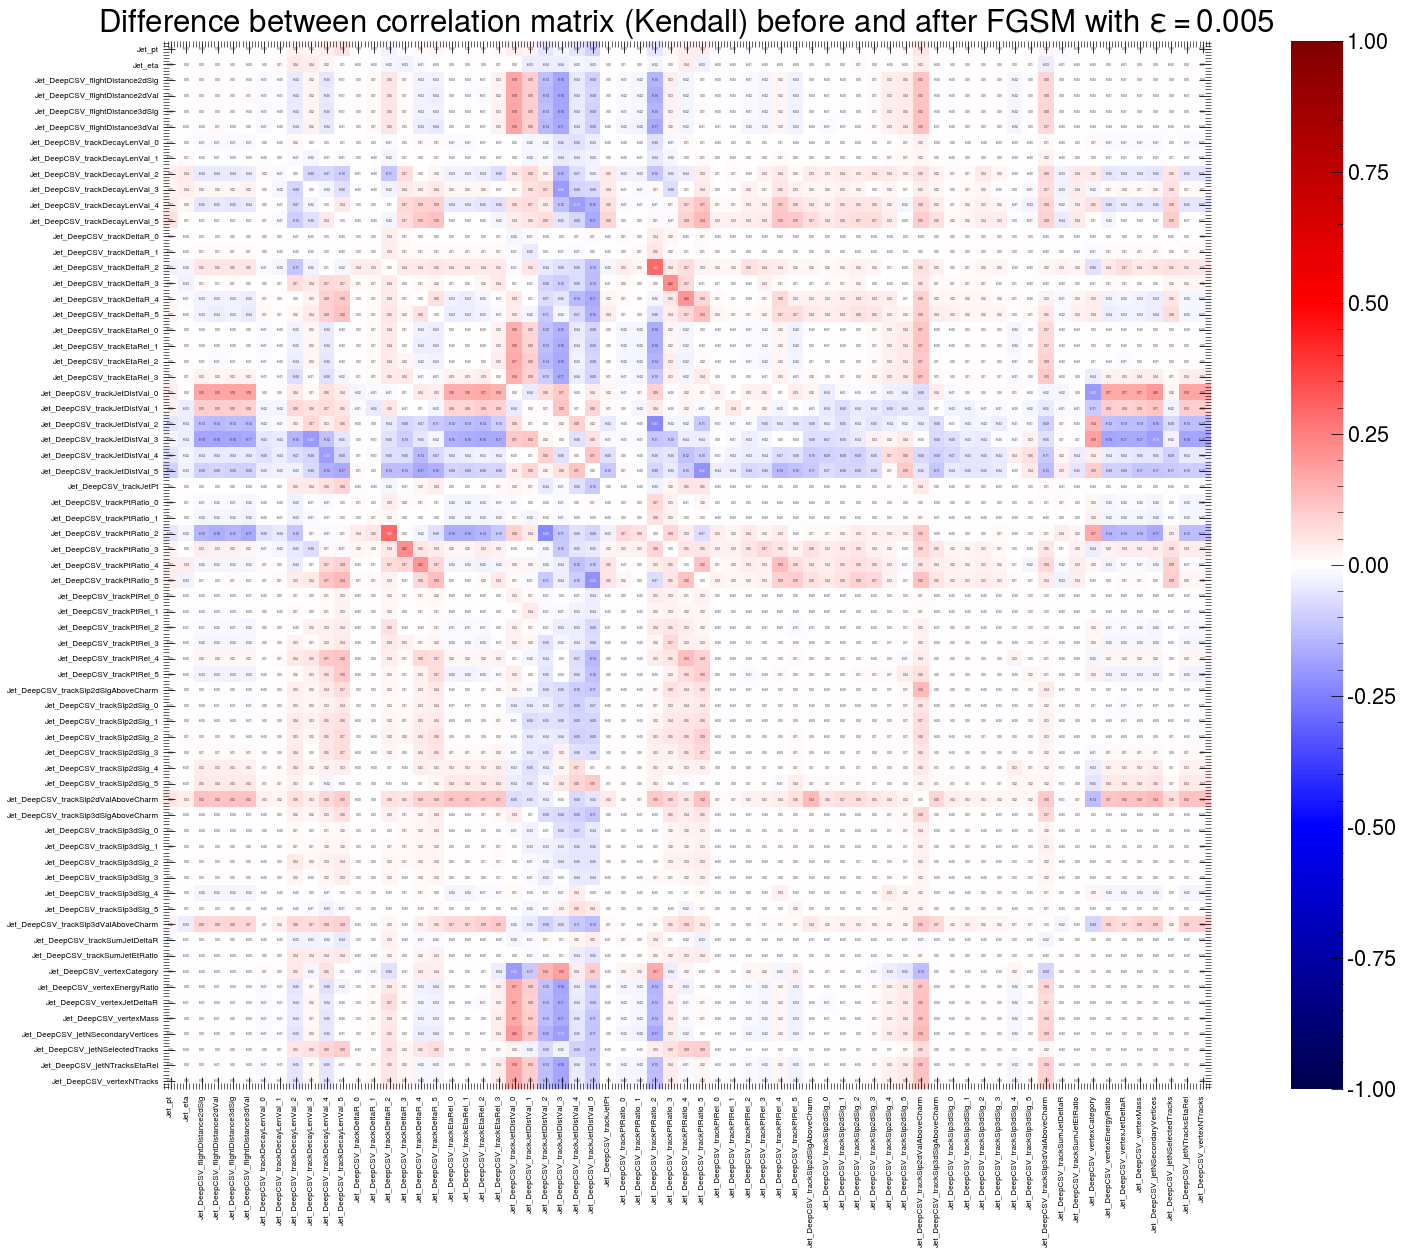

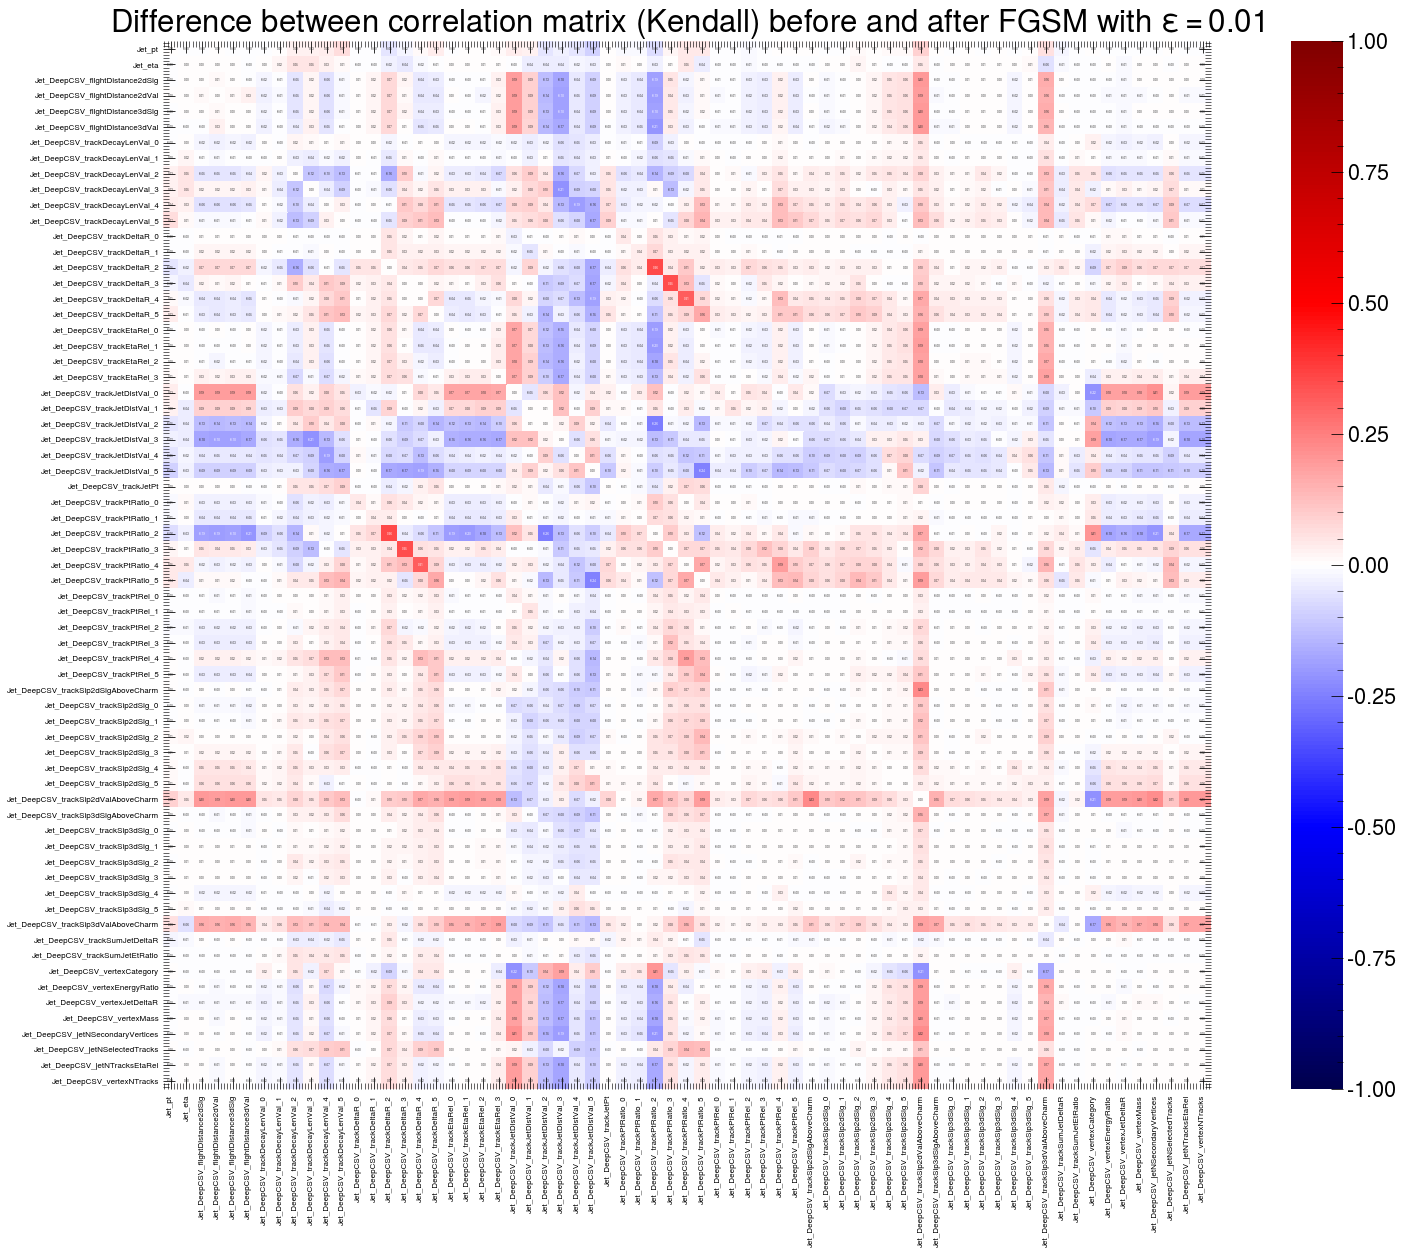

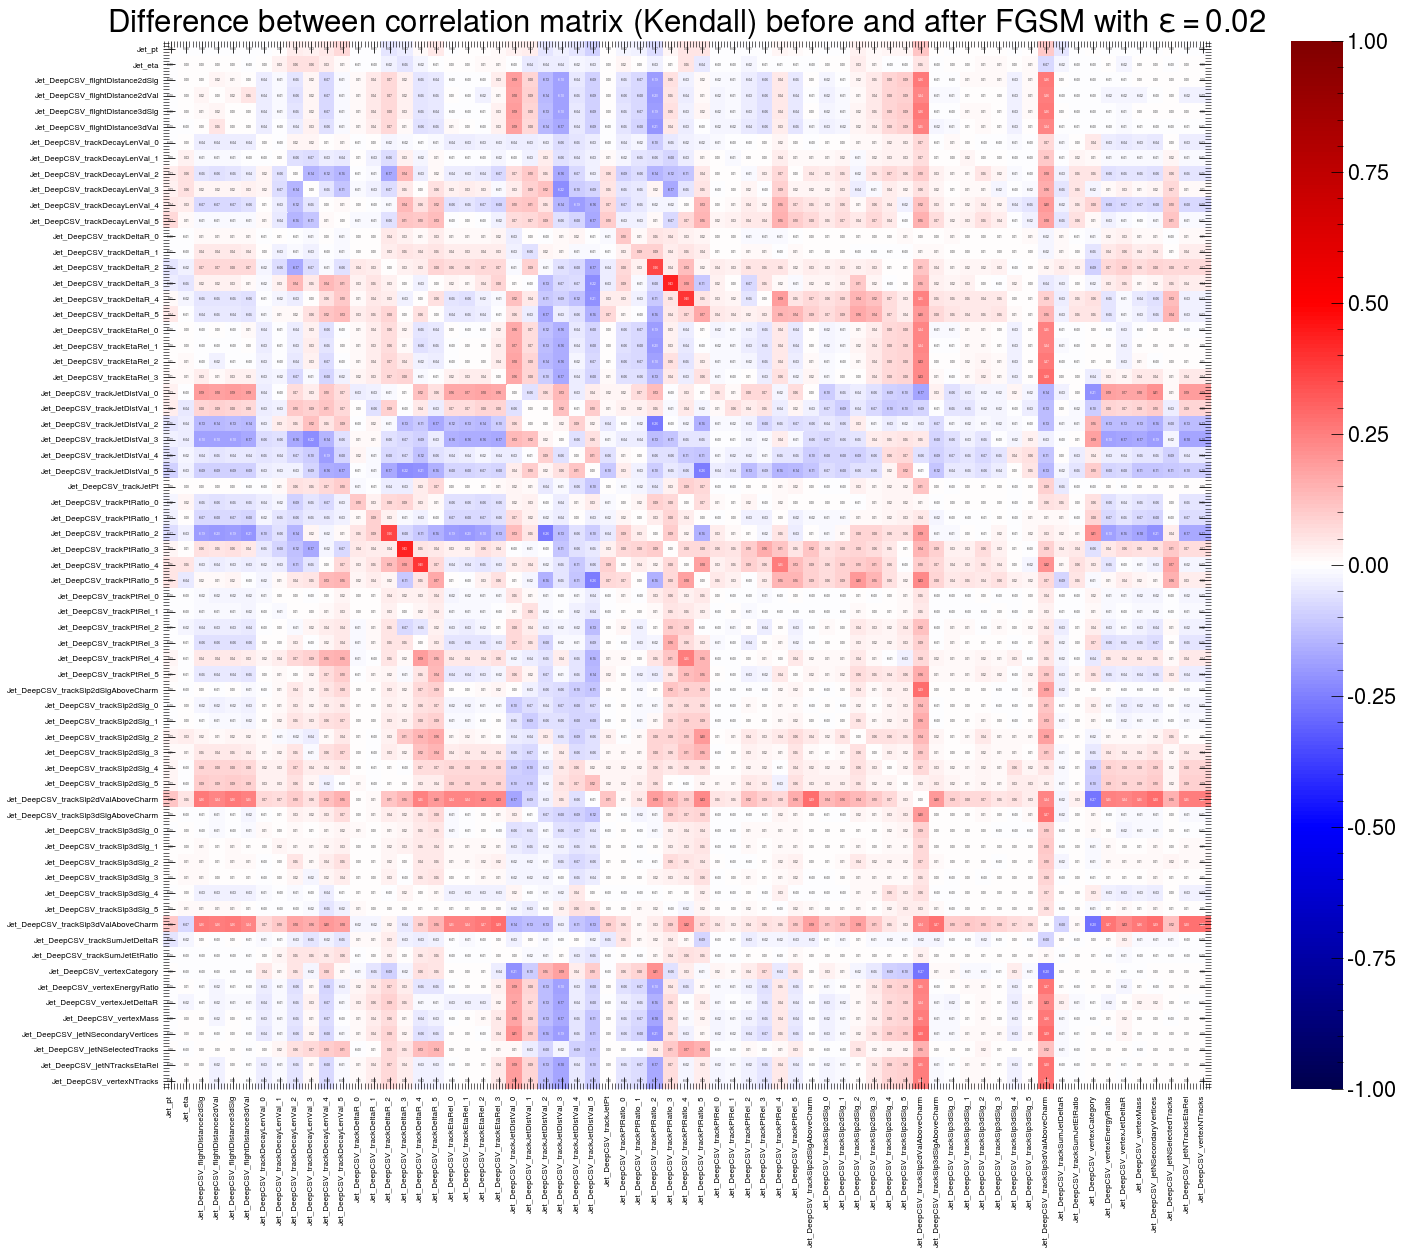

In [50]:
plot_diff_corr(attack_mode="fgsm", parameter=0.005, corr=corr_xadv_fgsm_0005, arr_corr=arr_corr_xadv_fgsm_0005)
plot_diff_corr(attack_mode="fgsm", parameter=0.01, corr=corr_xadv_fgsm_001, arr_corr=arr_corr_xadv_fgsm_001)
plot_diff_corr(attack_mode="fgsm", parameter=0.02, corr=corr_xadv_fgsm_002, arr_corr=arr_corr_xadv_fgsm_002)

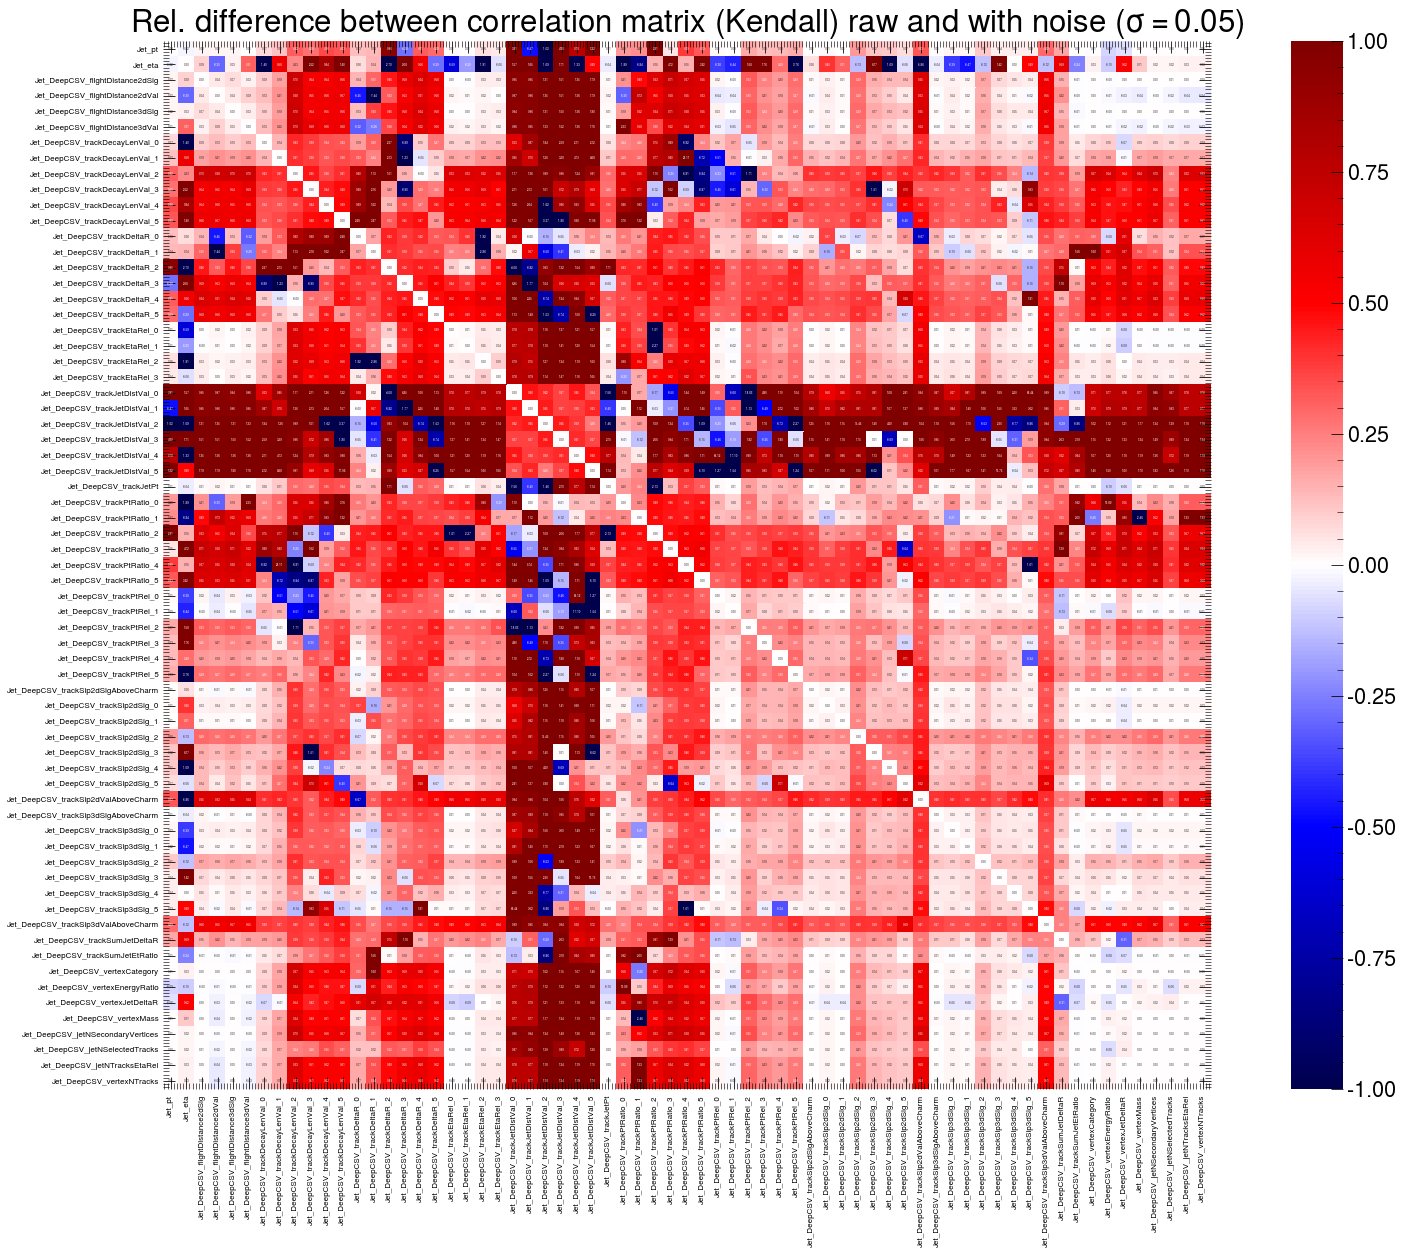

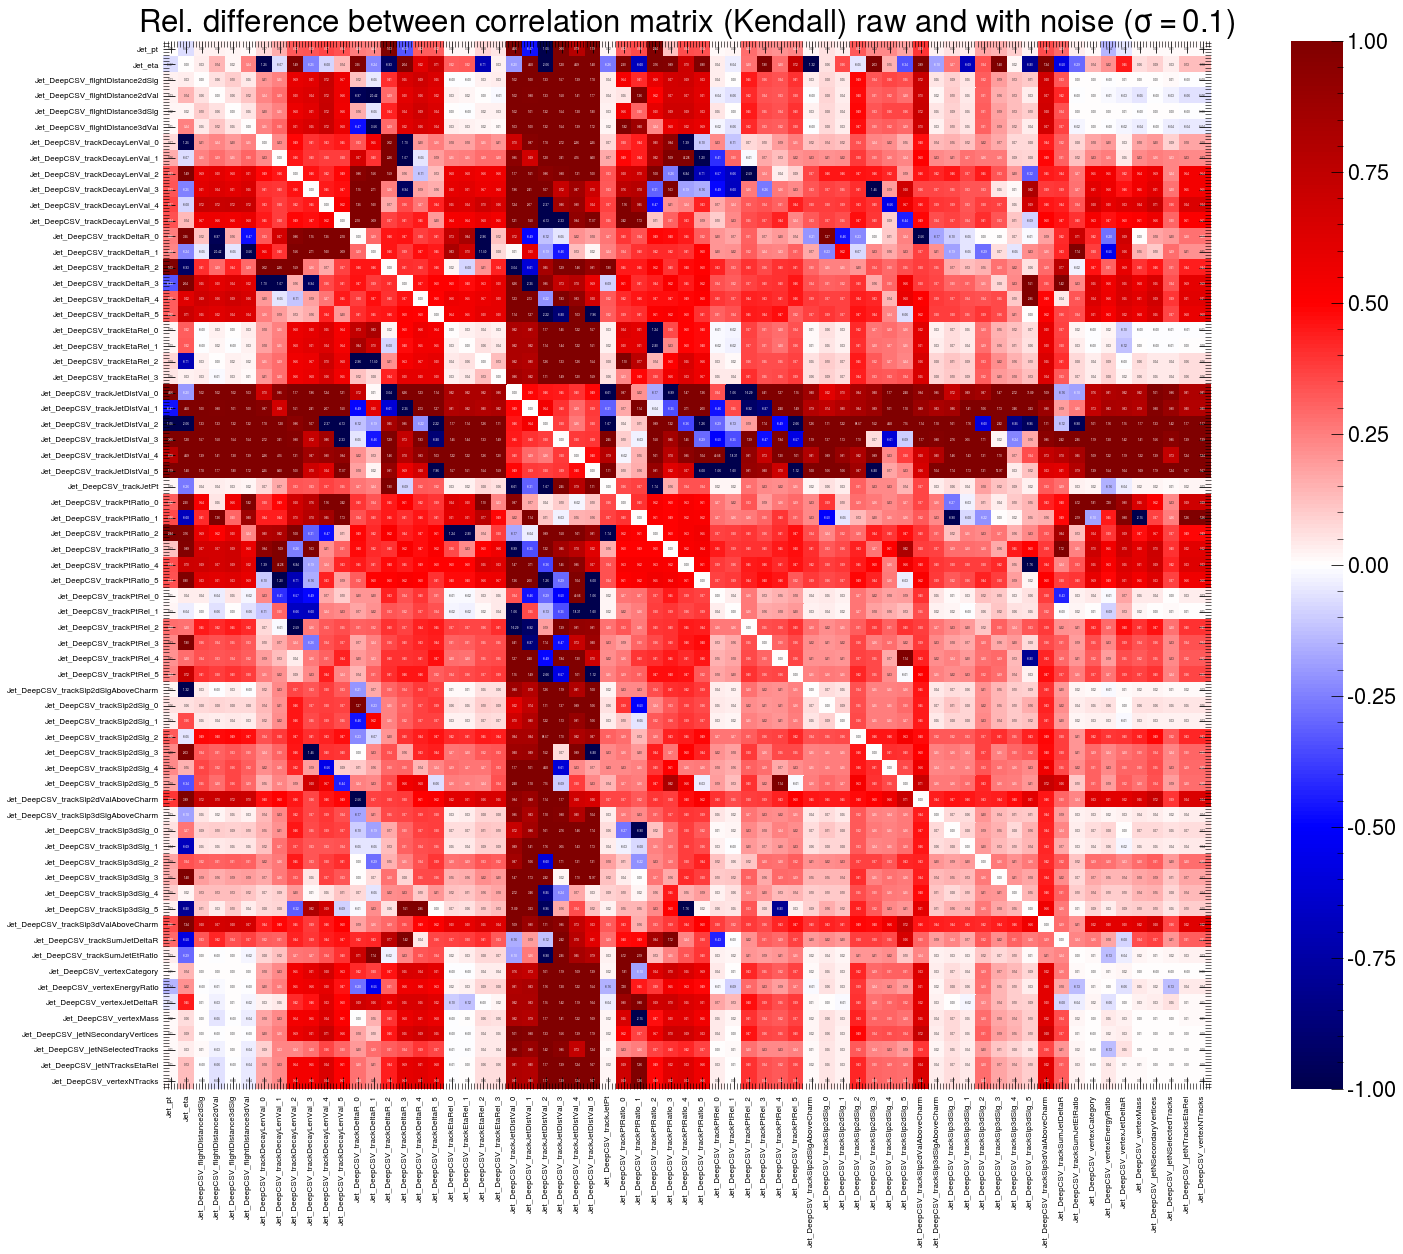

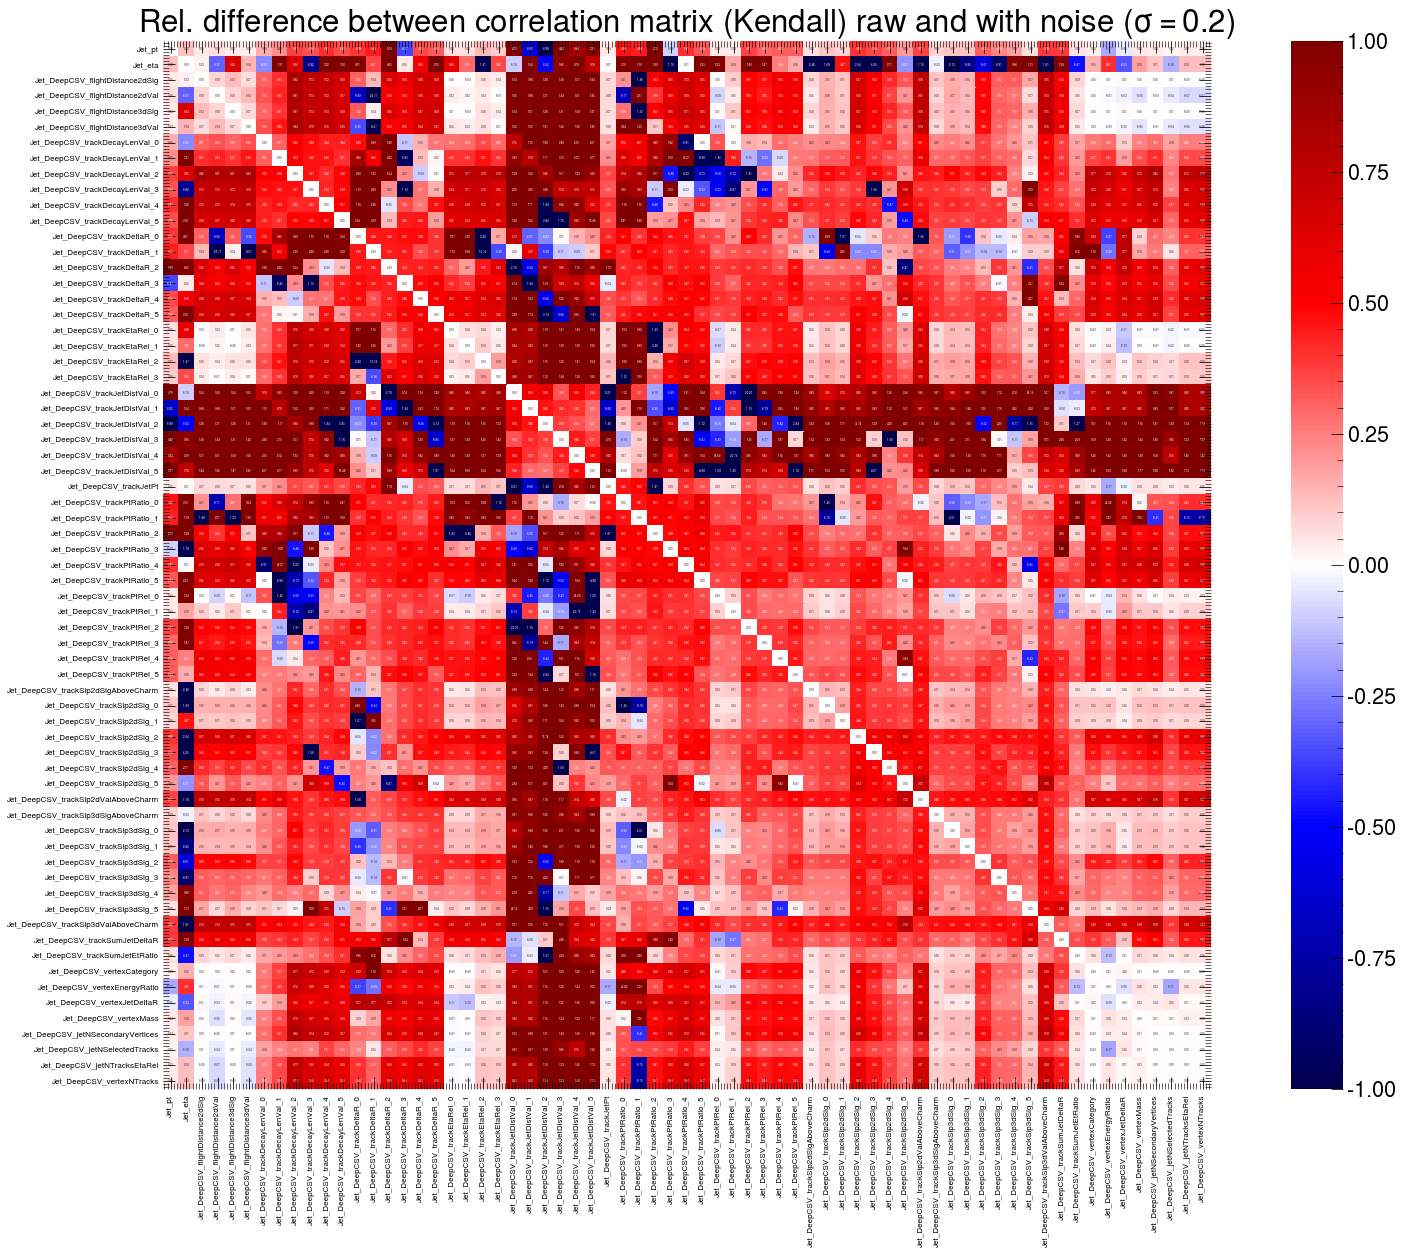

In [51]:
plot_rel_diff_corr(attack_mode="noise", parameter=0.05, corr=corr_xadv_noise_005, arr_corr=arr_corr_xadv_noise_005)
plot_rel_diff_corr(attack_mode="noise", parameter=0.1, corr=corr_xadv_noise_01, arr_corr=arr_corr_xadv_noise_01)
plot_rel_diff_corr(attack_mode="noise", parameter=0.2, corr=corr_xadv_noise_02, arr_corr=arr_corr_xadv_noise_02)

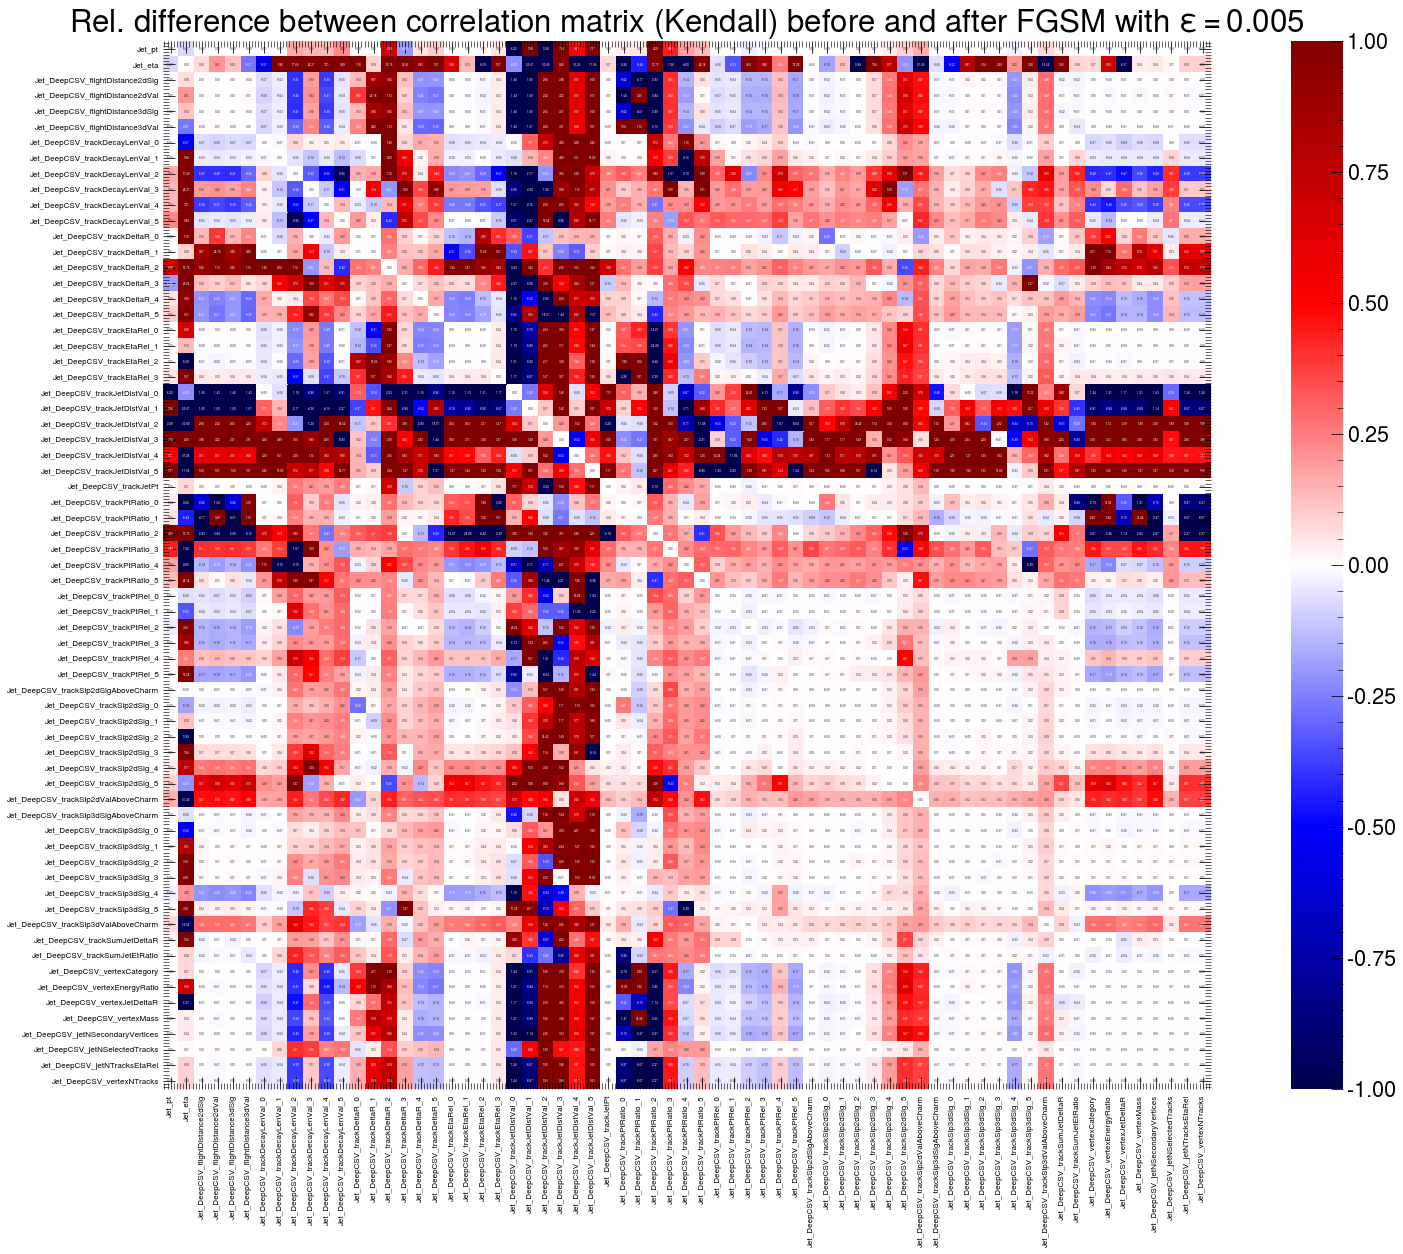

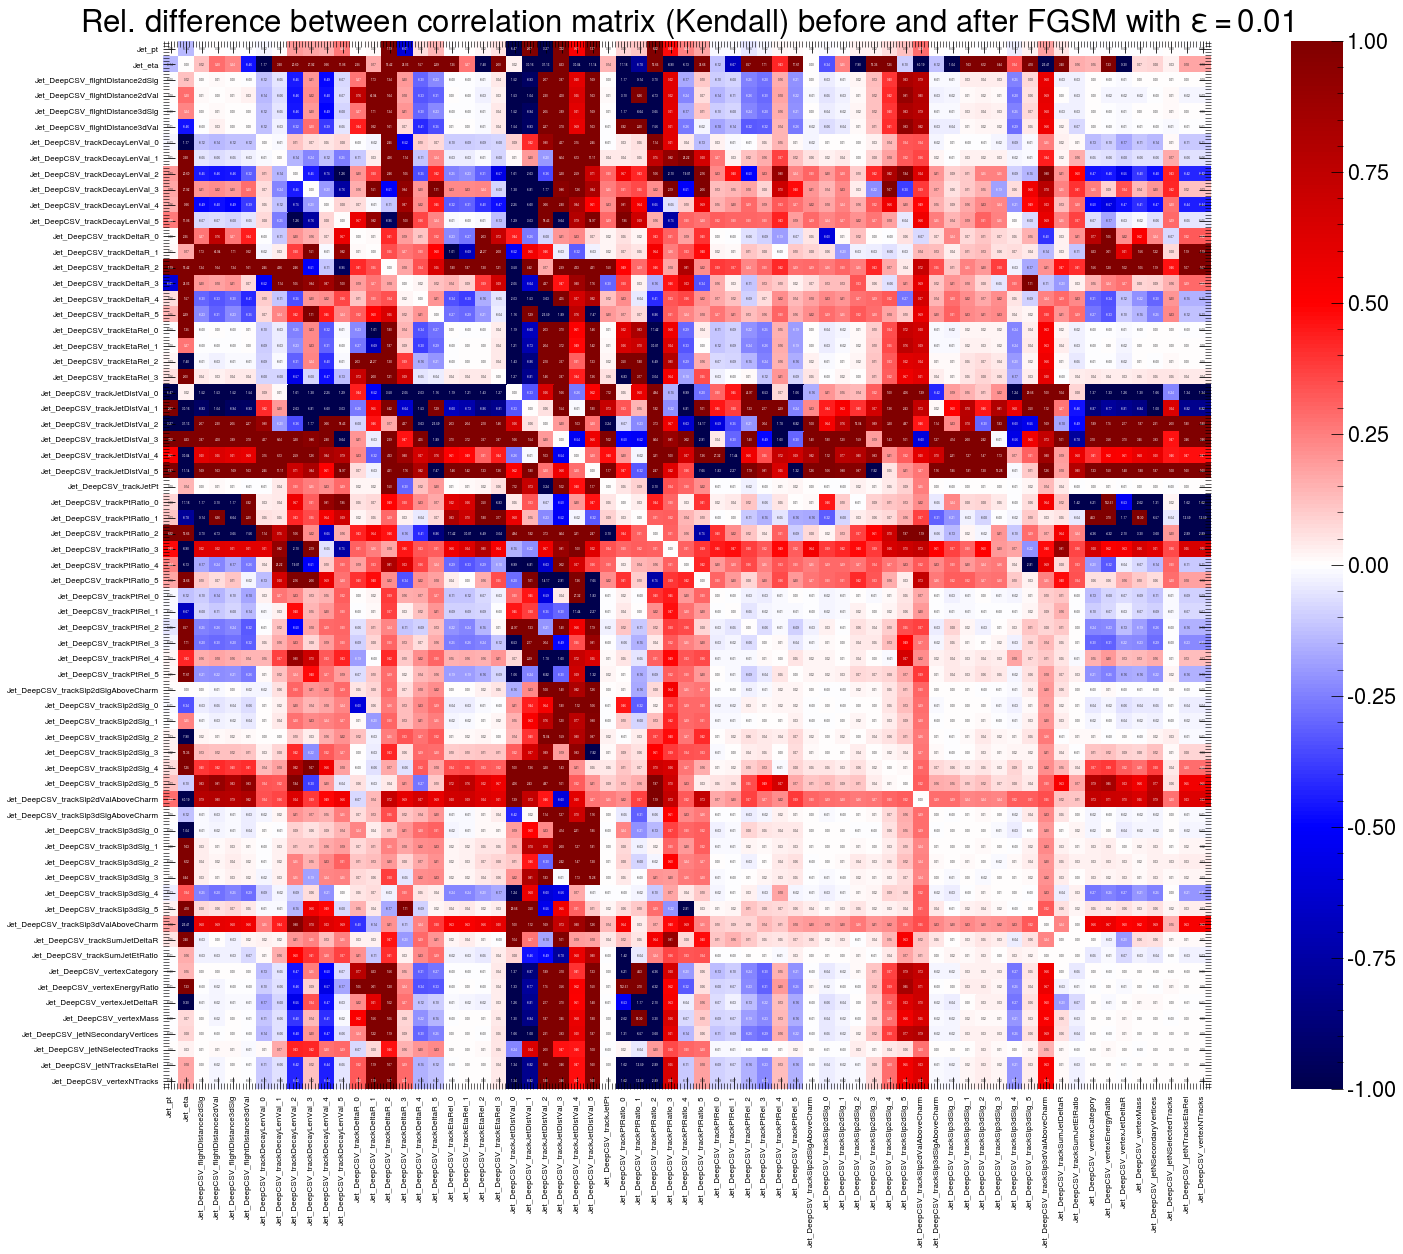

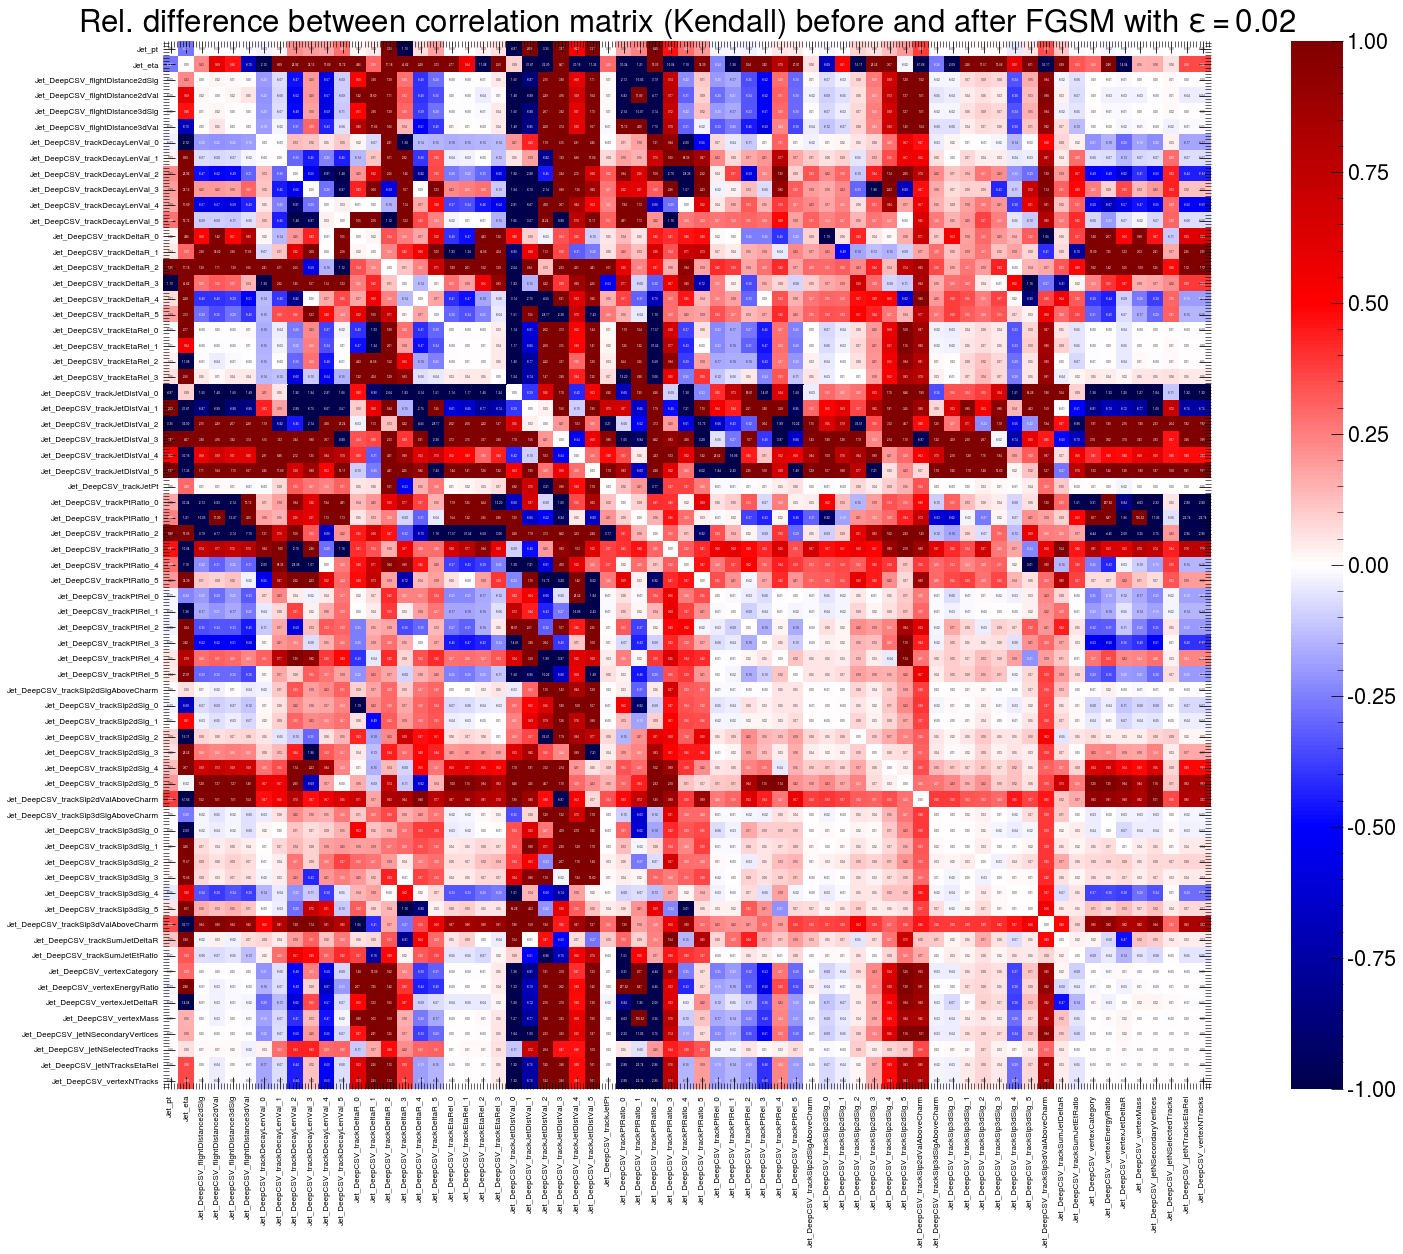

In [52]:
plot_rel_diff_corr(attack_mode="fgsm", parameter=0.005, corr=corr_xadv_fgsm_0005, arr_corr=arr_corr_xadv_fgsm_0005)
plot_rel_diff_corr(attack_mode="fgsm", parameter=0.01, corr=corr_xadv_fgsm_001, arr_corr=arr_corr_xadv_fgsm_001)
plot_rel_diff_corr(attack_mode="fgsm", parameter=0.02, corr=corr_xadv_fgsm_002, arr_corr=arr_corr_xadv_fgsm_002)